In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
from uncertainties import ufloat
import uncertainties
import copy
import string
from matplotlib.lines import Line2D

# Helper functions

## Customize plots

In [8]:
class ShorthandFormatter(string.Formatter):

    def format_field(self, value, format_spec):
        if isinstance(value, uncertainties.UFloat):
            return value.format(format_spec+'S')  # Shorthand option added
        # Special formatting for other types can be added here (floats, etc.)
        else:
            # Usual formatting:
            return super(ShorthandFormatter, self).format_field(
                value, format_spec)
fmtr = ShorthandFormatter()

def dp():
    jtplot.style(theme = 'monokai', grid = False, ticks = True)
    plot_resize()

def lp():
    jtplot.style(theme = 'default', grid = False, ticks = True)
    plot_resize()
    
def rp():
    jtplot.reset()
    plot_resize()

def plot_resize():
    plt.rcParams['figure.figsize'] = (4.8,3.6)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams.update({'figure.subplot.top': 0.98, 'figure.subplot.bottom': 0.2, 'figure.subplot.left': 0.18, 'figure.subplot.right': 0.98})

dp()
#jtplot.reset()
#jtplot.style(theme = 'monokai', grid = False, ticks = True)


## Other functions

In [3]:
def running_average(arr, L = 1, add_edges = False):
    #returns input immediately if the filter length is 1
    if L == 1 or L == 0:
        return arr

    #for uneven filter length, take average of values left and right around each point
    if L%2 == 1:
        l = int((L-1)/2)
        if add_edges:
            return np.array([0 for i in range(l)] + [sum(arr[i-l:i+l+1])/L for i in range(l, len(arr)-l)] + [0 for i in range(l)])
        else:
            return np.array([sum(arr[i-l:i+l+1])/L for i in range(l, len(arr)-l)])

    #for even filter length, take average value of points around a point between values
    else:
        l = int(L/2)
        if add_edges:
            return np.array([0 for i in range(l)] + [sum(arr[i-l:i+l])/L for i in range(l, len(arr)-l+1)] + [0 for i in range(l-1)])
        else:
            return np.array([sum(arr[i-l:i+l])/L for i in range(l, len(arr)-l+1)])

# Mit Multimeter

In [4]:
data_multi = pd.read_csv('Messdaten_Multimeter.csv')
data_multi

uB/mV  Uv/mV  dUV/mV
0       0.4   -370       5
1    1770.0   -377       5
2    5530.0   -377       5
3   10380.0   -100      20
4   15230.0    410      20
5   20430.0    840      20
6   26250.0   -110      20
7   31840.0    710      20
8   36630.0   1660      20
9   41500.0   1200      20
10  44800.0    770      20
11  50500.0   1270      20
12  57600.0   2380      20
13  64000.0   2220      40
14  71200.0   2600     100
15  81000.0   3590      50

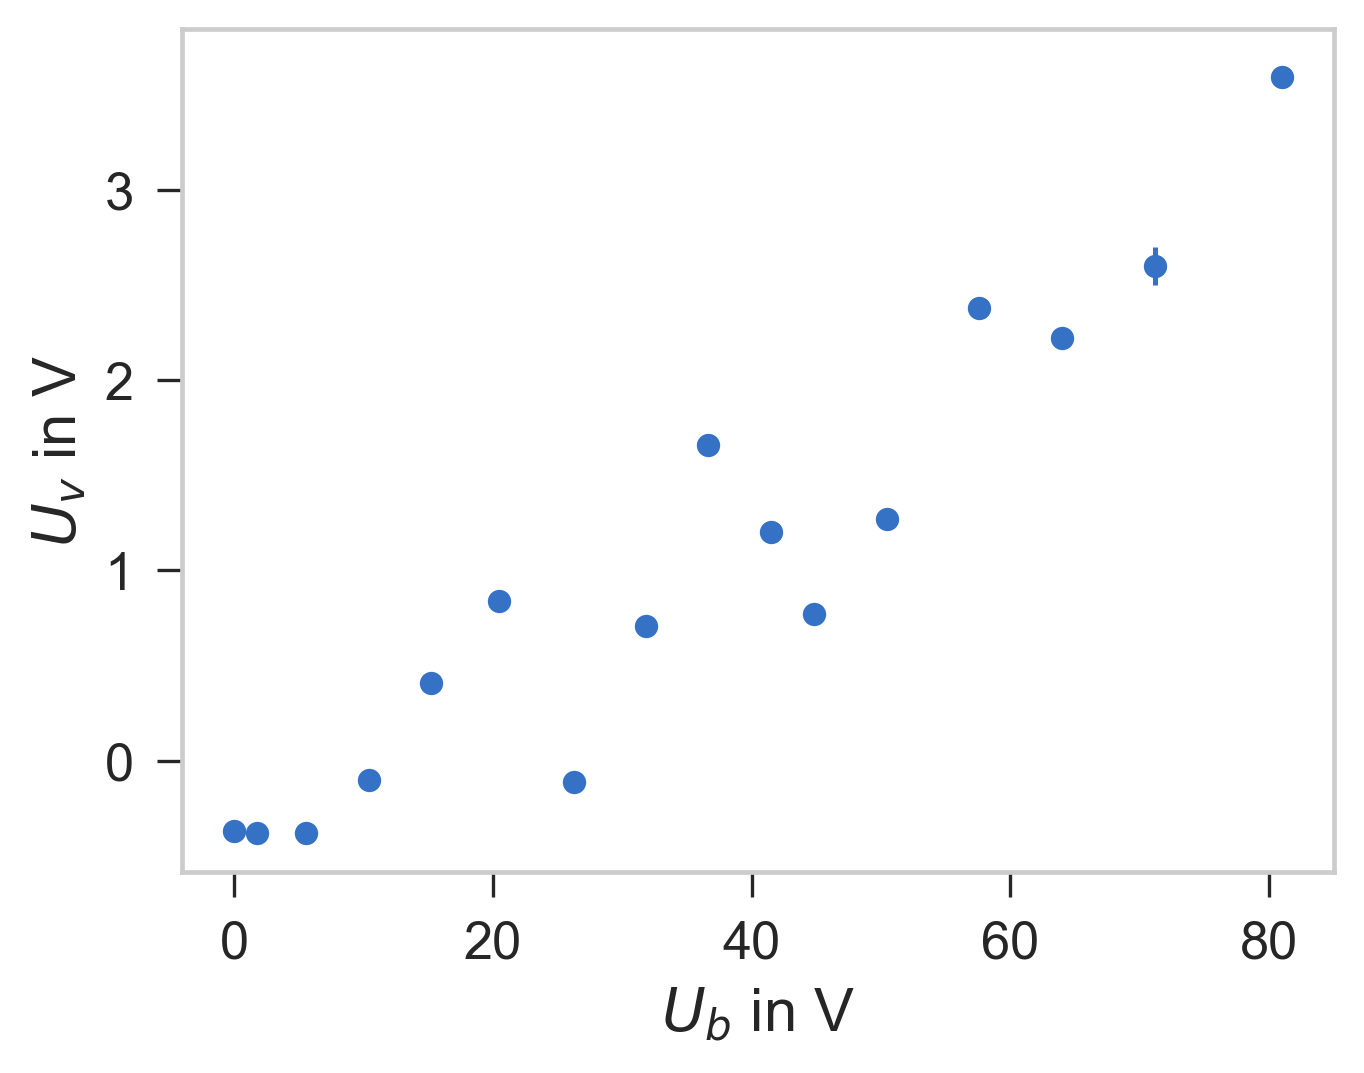

In [113]:
lp()
plt.errorbar(data_multi['uB/mV']/1000, data_multi['Uv/mV']/1000, yerr = data_multi['dUV/mV']/1000, fmt = 'bo', capsize = 2)

plt.title('')
plt.xlabel('$U_b$ in V')
plt.ylabel('$U_v$ in V')

plt.savefig('Plots/multimeter')

plt.show()

# Oszilloskop

## Helper functions

In [5]:
def reset_index(df, keep_old = True):
    if keep_old and not 'old_index' in df.columns:
        df['old_index'] = df.index
    df.index = np.arange(len(df[:]))
    return df
    
def remove_jump(df, col, rel_jump_size = 0.1, index_reset = True):
    data = df[col]
    max_val = max(data)
    min_val = min(data)
    
    for i in range(data.index[0], data.index[-1] - 1):
        if abs(data[i+1]-data[i]) > rel_jump_size*(max_val-min_val):
            break
    if index_reset:
        return reset_index(df[:][:i-1])
    else:
        return df[:][:i-1]

def remove_zero(df, col, threshold = 0.08, still_more = 10, index_reset = True):
    data = df[col]
    counter = 0
    for i in range(data.index[0], data.index[-1] - still_more):
        if counter >= still_more:
            break
        if data[i] > threshold:
            counter += 1
        else:
            counter = 0
    if index_reset:
        return reset_index(df[:][i-still_more:])
    else:
        return df[:][i-still_more:]

def format_dataframe(df, jump_th = 0.1, running_average_length = 100):
    df.pop('CH1 Peak Detect')
    df.pop('CH2 Peak Detect')
    df = df.rename(columns = {'CH1': 'U_b', 'CH2': 'U_v'})
    
    #df_a contains only first measurement
    df_a = remove_zero(df, col = 'U_b')
    df_a = remove_jump(df_a, col = 'U_v', rel_jump_size = jump_th)

    #df2 for second measurement
    df_b = reset_index(df[:][80000:])
    df_b = remove_jump(df_b, col = 'U_v', rel_jump_size = jump_th)
    df_b = remove_zero(df_b, col = 'U_b')

    df = df_a.join(df_b, lsuffix = '_1', rsuffix = '_2')
    
    for col in ['U_b_1', 'U_b_2', 'U_v_1', 'U_v_2']:
        df[col + '_smooth'] = running_average(df[col], running_average_length, add_edges = True)
    return df

## Get and format data

In [27]:
df_gr = pd.read_csv('Oszilloskop/T0001ALL.CSV', header = 14)
df_G4V = pd.read_csv('Oszilloskop/T0002ALL.CSV', header = 14)
df_G8V = pd.read_csv('Oszilloskop/T0003.CSV', header = 14)
df_H7 = pd.read_csv('Oszilloskop/T0004.CSV', header = 14)
df_H4 = pd.read_csv('Oszilloskop/T0005.CSV', header = 14)
df_H2 = pd.read_csv('Oszilloskop/T0006.CSV', header = 14)

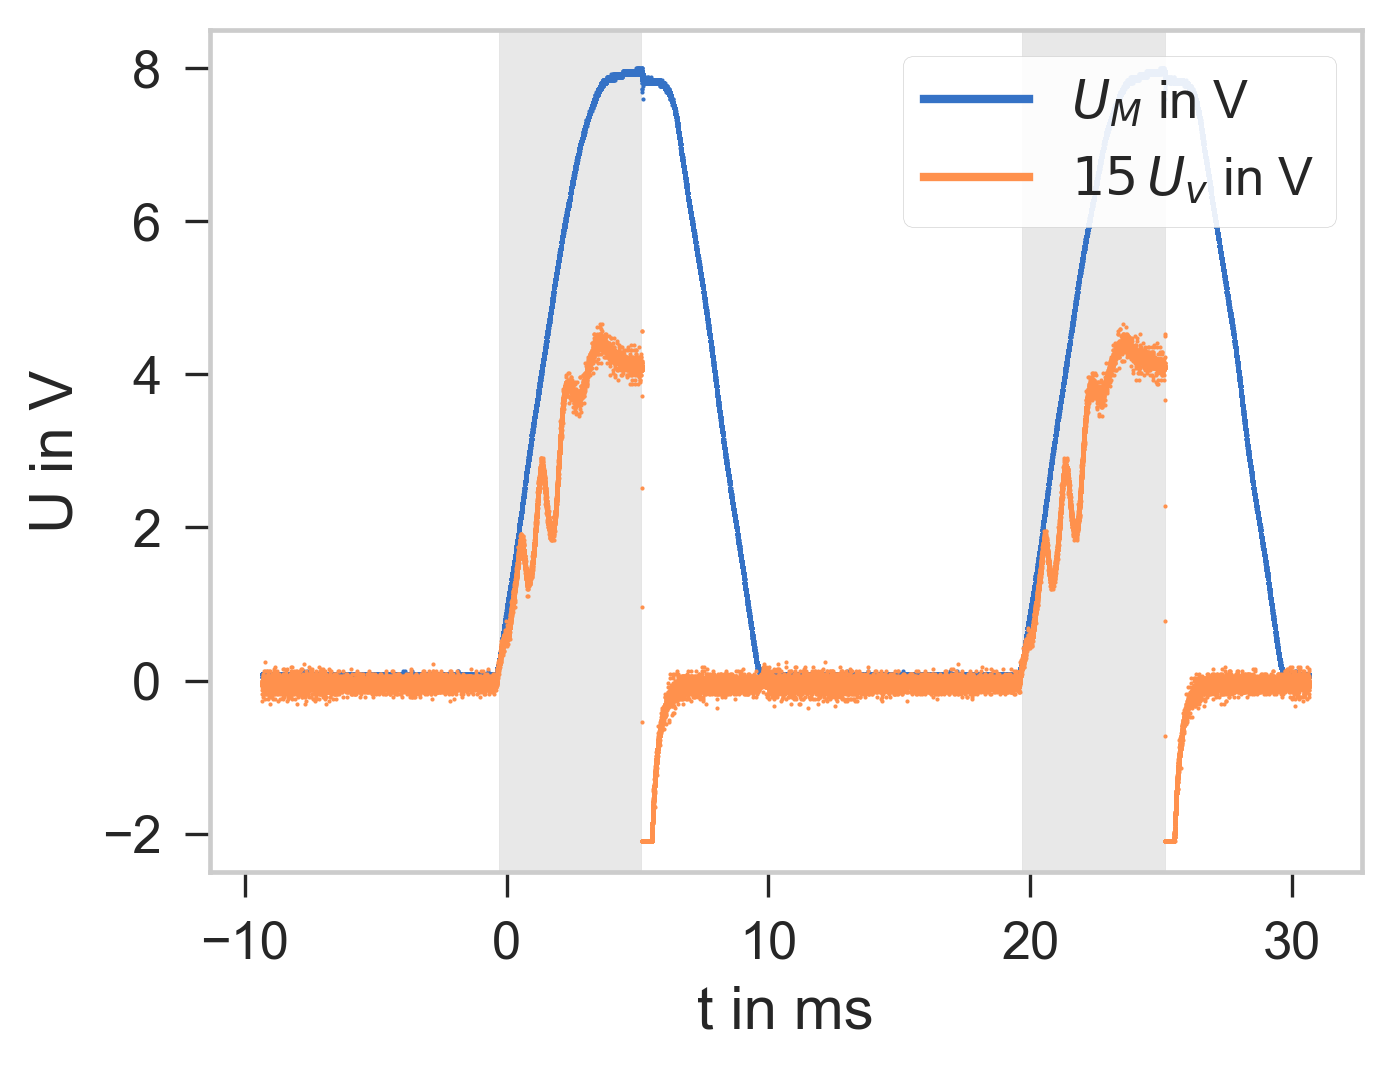

In [122]:
from matplotlib.lines import Line2D

lp()
df = df_gr
plt.plot(1000*df['TIME'], df['CH1'], 'b.', markersize = 2)
plt.plot(1000*df['TIME'], 15*df['CH2'], 'y.', markersize = 2)

plt.fill_between([-0.3,5.15],[9,9], y2 = [-3,-3], alpha = 0.1, color = 'k')
plt.fill_between([19.7,25.15],[9,9], y2 = [-3,-3], alpha = 0.1, color = 'k')

plt.ylim(-2.5,8.5)

plt.xlabel('t in ms')
plt.ylabel('U in V')

custom_lines = [Line2D([0], [0], color='b', lw=2, label = '$U_M$ in V'), Line2D([0], [0], color='y', lw=2,  label = '$15\, U_v$ in V')]

plt.legend(handles = custom_lines, loc = 'upper right', framealpha = 0.9)
plt.savefig('Plots/raw_data_grund')
plt.show()

### Delete not interesting datapoints

In [11]:
df_gr = format_dataframe(df_gr)
df_G4V = format_dataframe(df_G4V)
df_G8V = format_dataframe(df_G8V)
df_H7 = format_dataframe(df_H7, jump_th = 0.05)
df_H4 = format_dataframe(df_H4)
df_H2 = format_dataframe(df_H2, jump_th = 0.15)

#create dictionary with datafames
data = {'grund': df_gr, 'G4V': df_G4V, 'G8V': df_G8V, 'H7': df_H7, 'H4': df_H4, 'H2': df_H2}

KeyboardInterrupt: 

### Save sliced data

In [22]:
#save data
for name, df in data.items():
    s = df.to_csv(line_terminator = '\n')
    
    f = open(f'Oszilloskop/sliced/{name}.csv', 'w')
    f.write(s)
    f.close()

### Retrieve sliced data

In [6]:
#retrieve data
keys = ['grund', 'G4V', 'G8V', 'H7', 'H4', 'H2']
data = {}

for key in keys:
    df = pd.read_csv(f'Oszilloskop/sliced/{key}.csv')
    data[key] = df

### Save settings for each measurement

In [7]:
#save measurement settings
measurement_settings = {}
measurement_settings['grund'] = {'CH1': 1, 'CH2': 0.05, 'verstaerkung': 'minimal', 'U_g_set': 6,
                                 'U_g': 5.73, 'U_b': 70, 'H_set': 5, 'U_h': 8.02, 'file': 'T0001ALL.csv'}

for key in list(data.keys())[1:]:
    measurement_settings[key] = copy.deepcopy(measurement_settings['grund'])

measurement_settings['G4V']['U_g_set'] = 4
measurement_settings['G4V']['U_g'] = 4.14
measurement_settings['G4V']['CH2'] = 0.1
measurement_settings['G4V']['file'] = 'T0002ALL.csv'

measurement_settings['G8V']['U_g_set'] = 8
measurement_settings['G8V']['U_g'] = 7.4
measurement_settings['G8V']['file'] = 'T0003.csv'

measurement_settings['H7']['H_set'] = 7
measurement_settings['H7']['U_h'] = None
measurement_settings['H7']['CH2'] = 0.2
measurement_settings['H7']['file'] = 'T0004.csv'

measurement_settings['H4']['H_set'] = 4
measurement_settings['H4']['U_h'] = None
measurement_settings['H4']['file'] = 'T0005.csv'

measurement_settings['H2']['H_set'] = 2
measurement_settings['H2']['U_h'] = None
measurement_settings['H2']['CH2'] = 0.02
measurement_settings['H2']['file'] = 'T0006.csv'

#save measurement settings
df_settings = pd.DataFrame(measurement_settings)
s = df_settings.to_csv(line_terminator = '\n')

f = open('Oszilloskop/settings.csv', 'w')
f.write(s)
f.close()

df_settings

grund           G4V        G8V         H7         H4  \
CH1                      1             1          1          1          1   
CH2                   0.05           0.1       0.05        0.2       0.05   
verstaerkung       minimal       minimal    minimal    minimal    minimal   
U_g_set                  6             4          8          6          6   
U_g                   5.73          4.14        7.4       5.73       5.73   
U_b                     70            70         70         70         70   
H_set                    5             5          5          7          4   
U_h                   8.02          8.02       8.02       None       None   
file          T0001ALL.csv  T0002ALL.csv  T0003.csv  T0004.csv  T0005.csv   

                     H2  
CH1                   1  
CH2                0.02  
verstaerkung    minimal  
U_g_set               6  
U_g                5.73  
U_b                  70  
H_set                 2  
U_h                None  
file          T0006.csv

## Plot

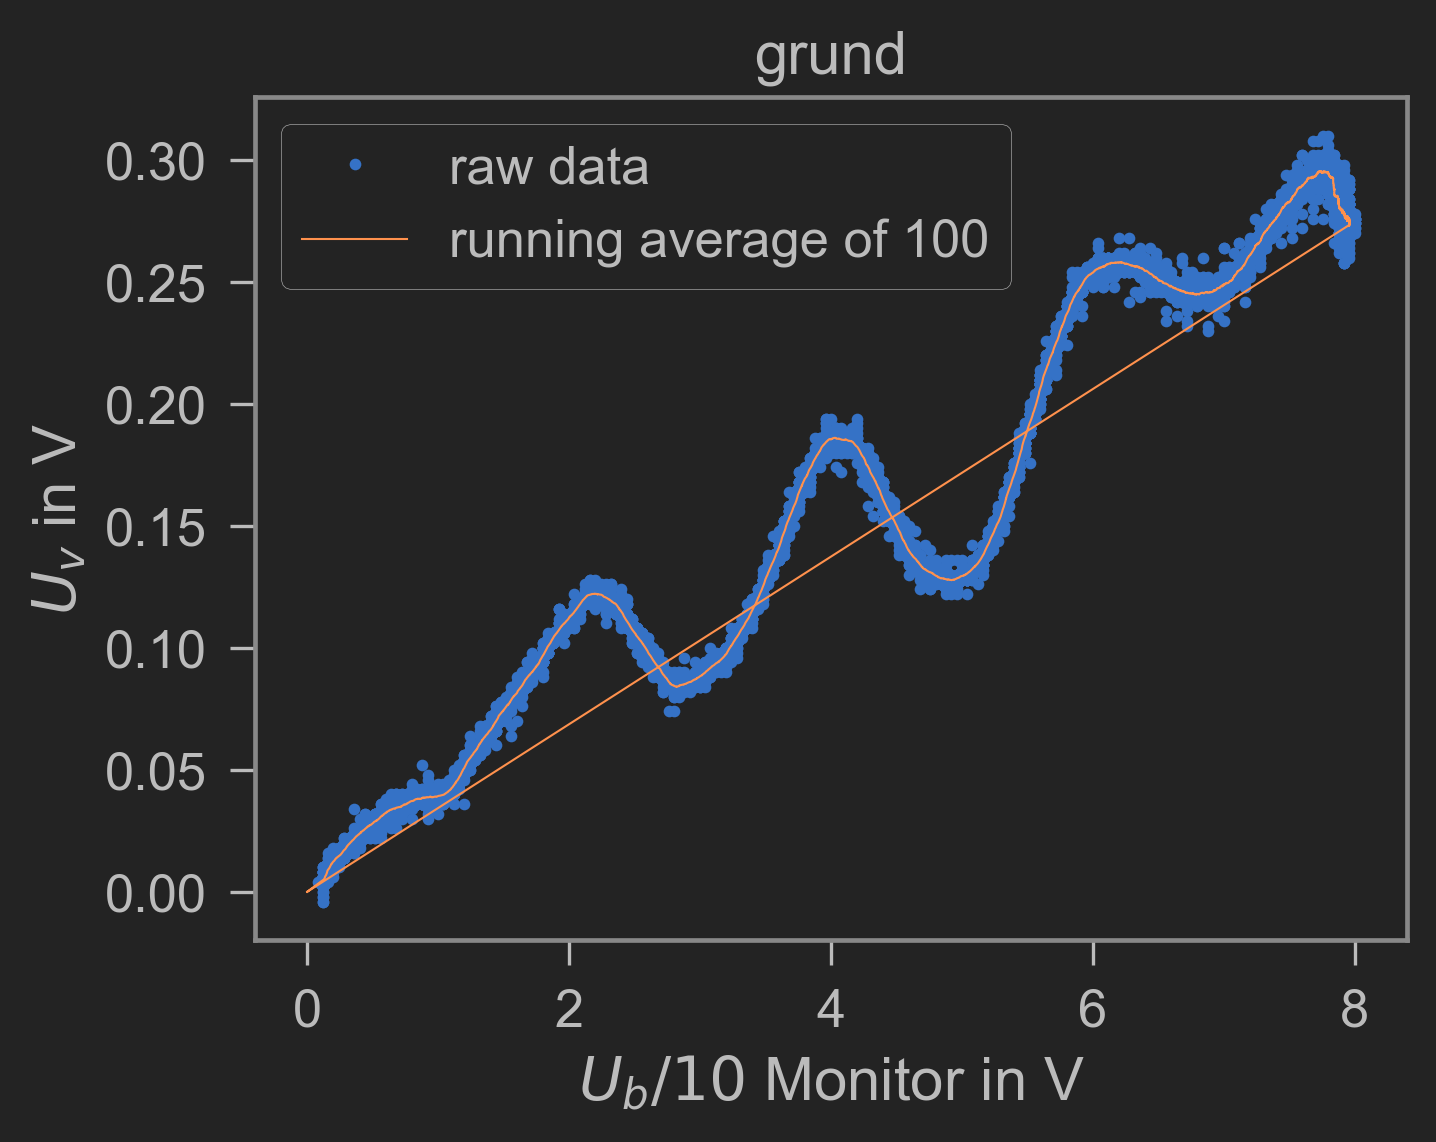

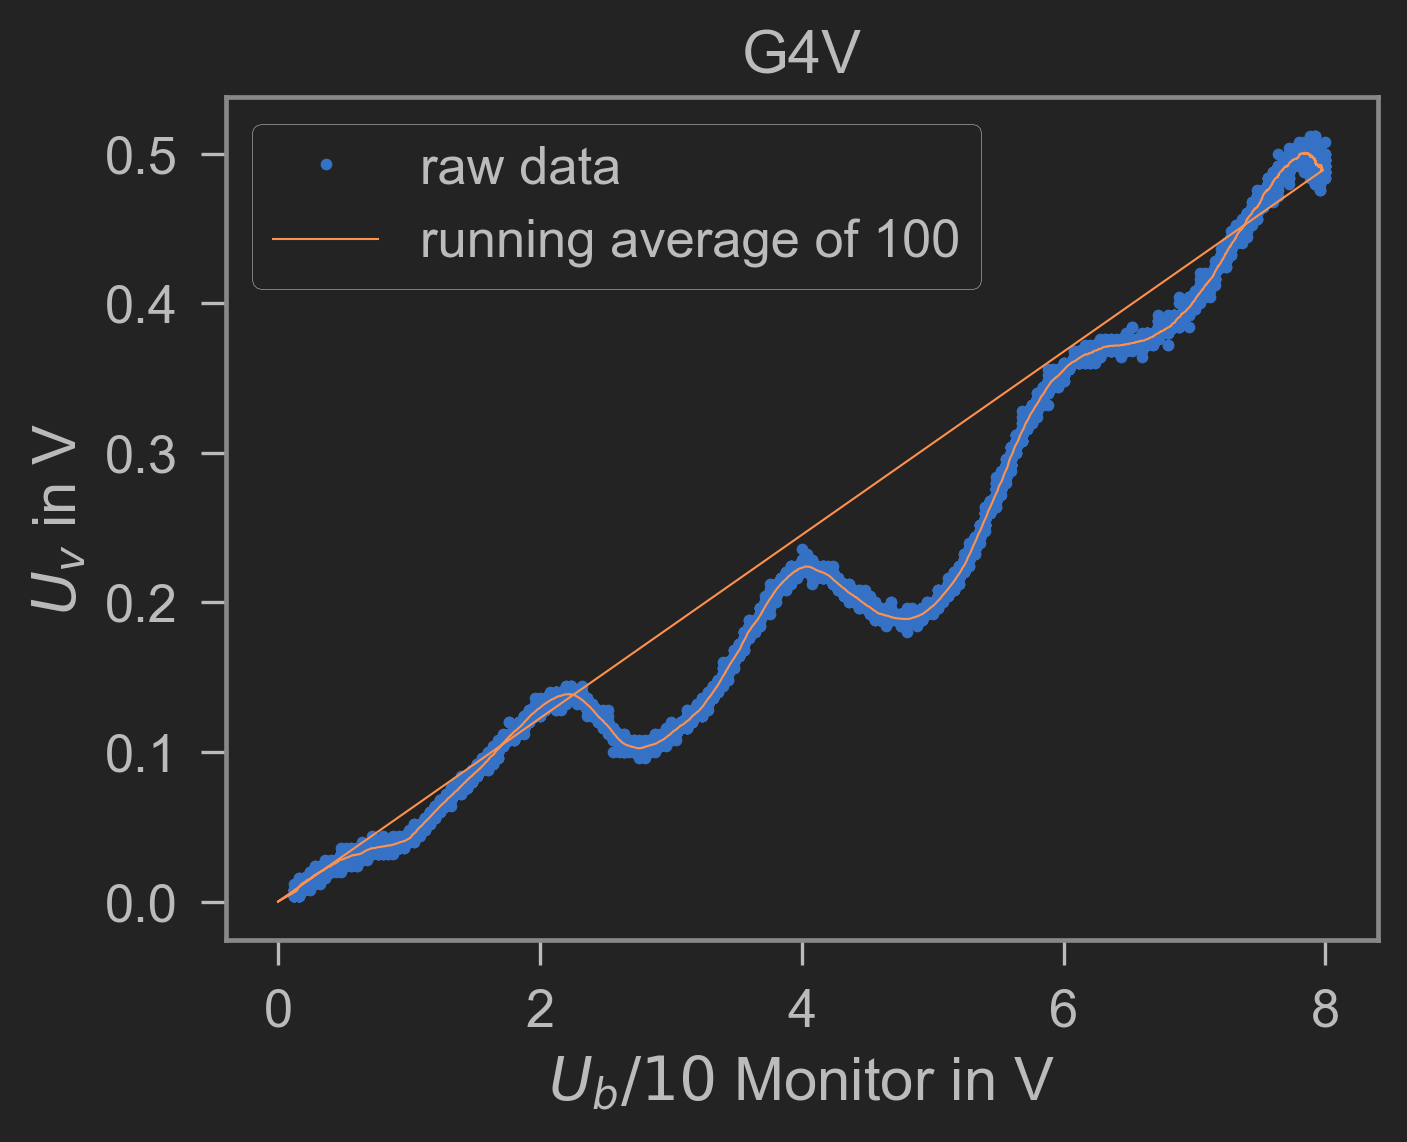

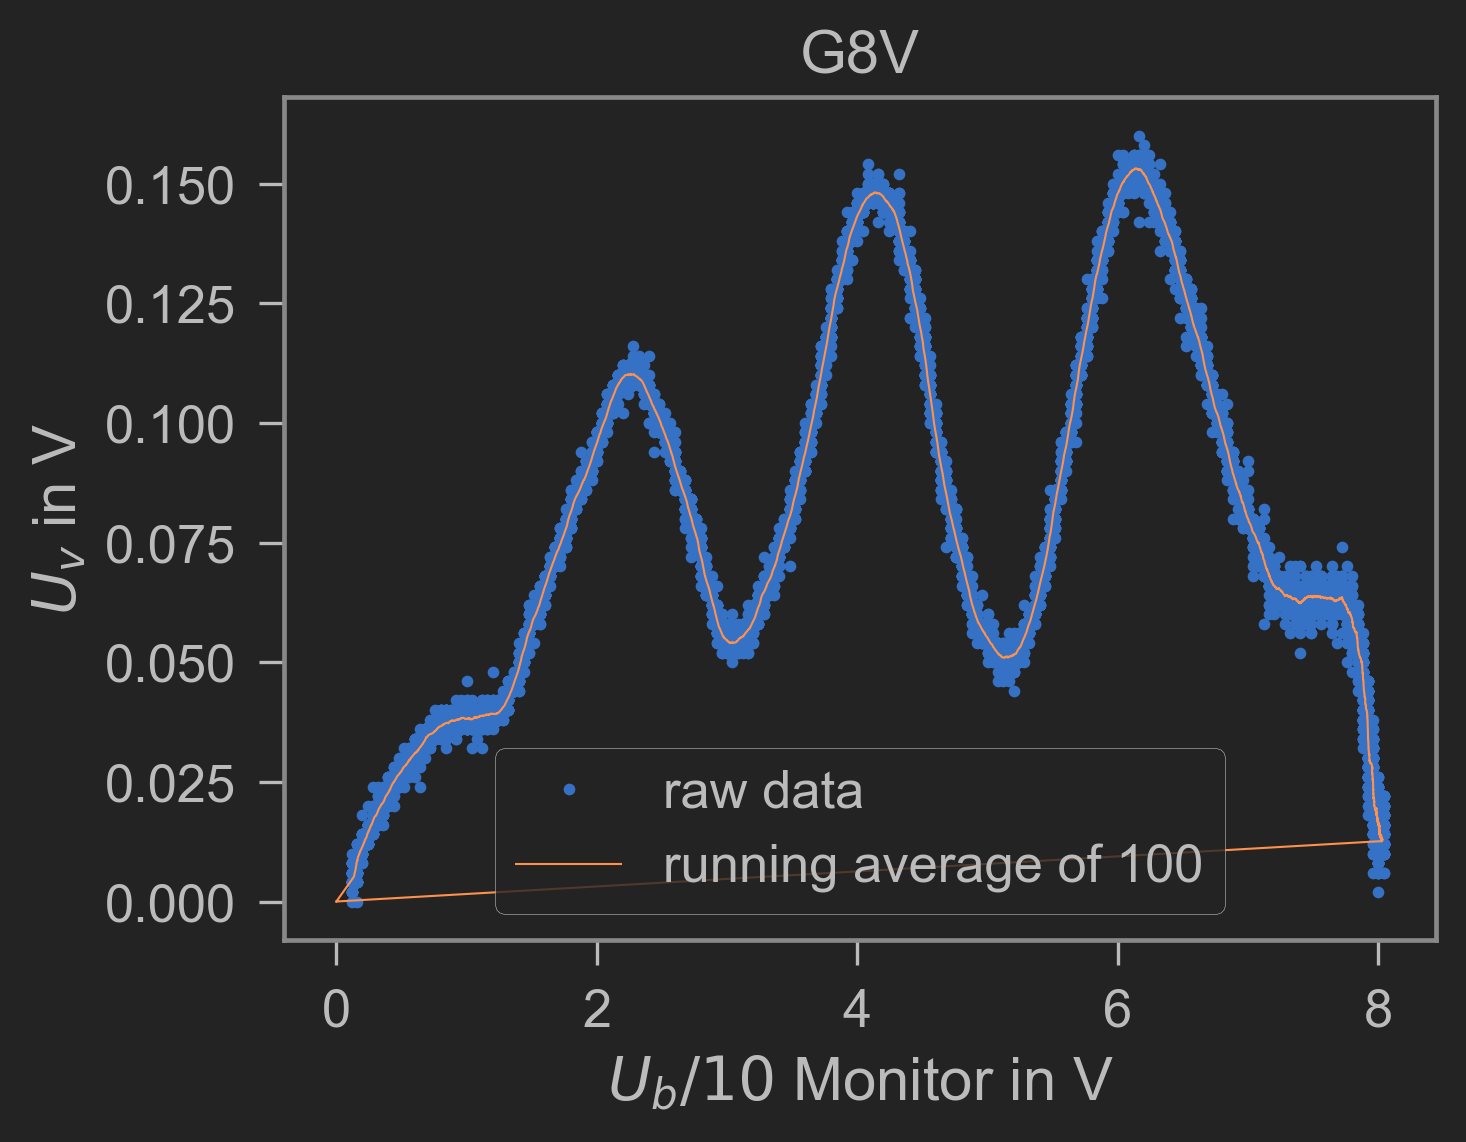

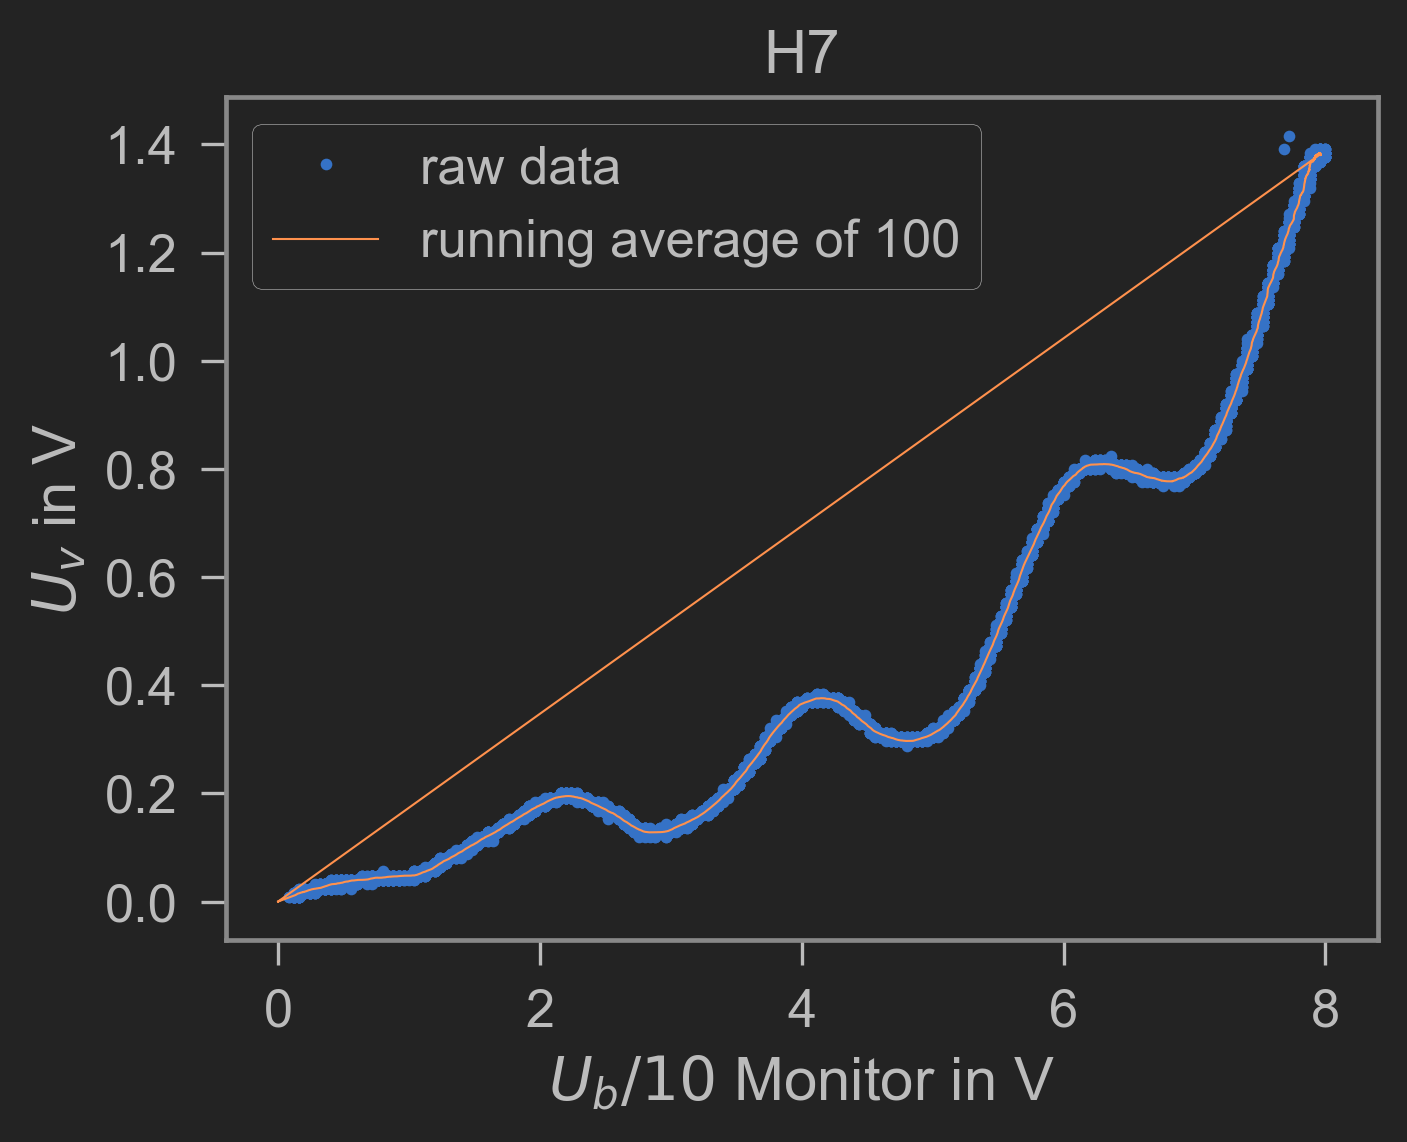

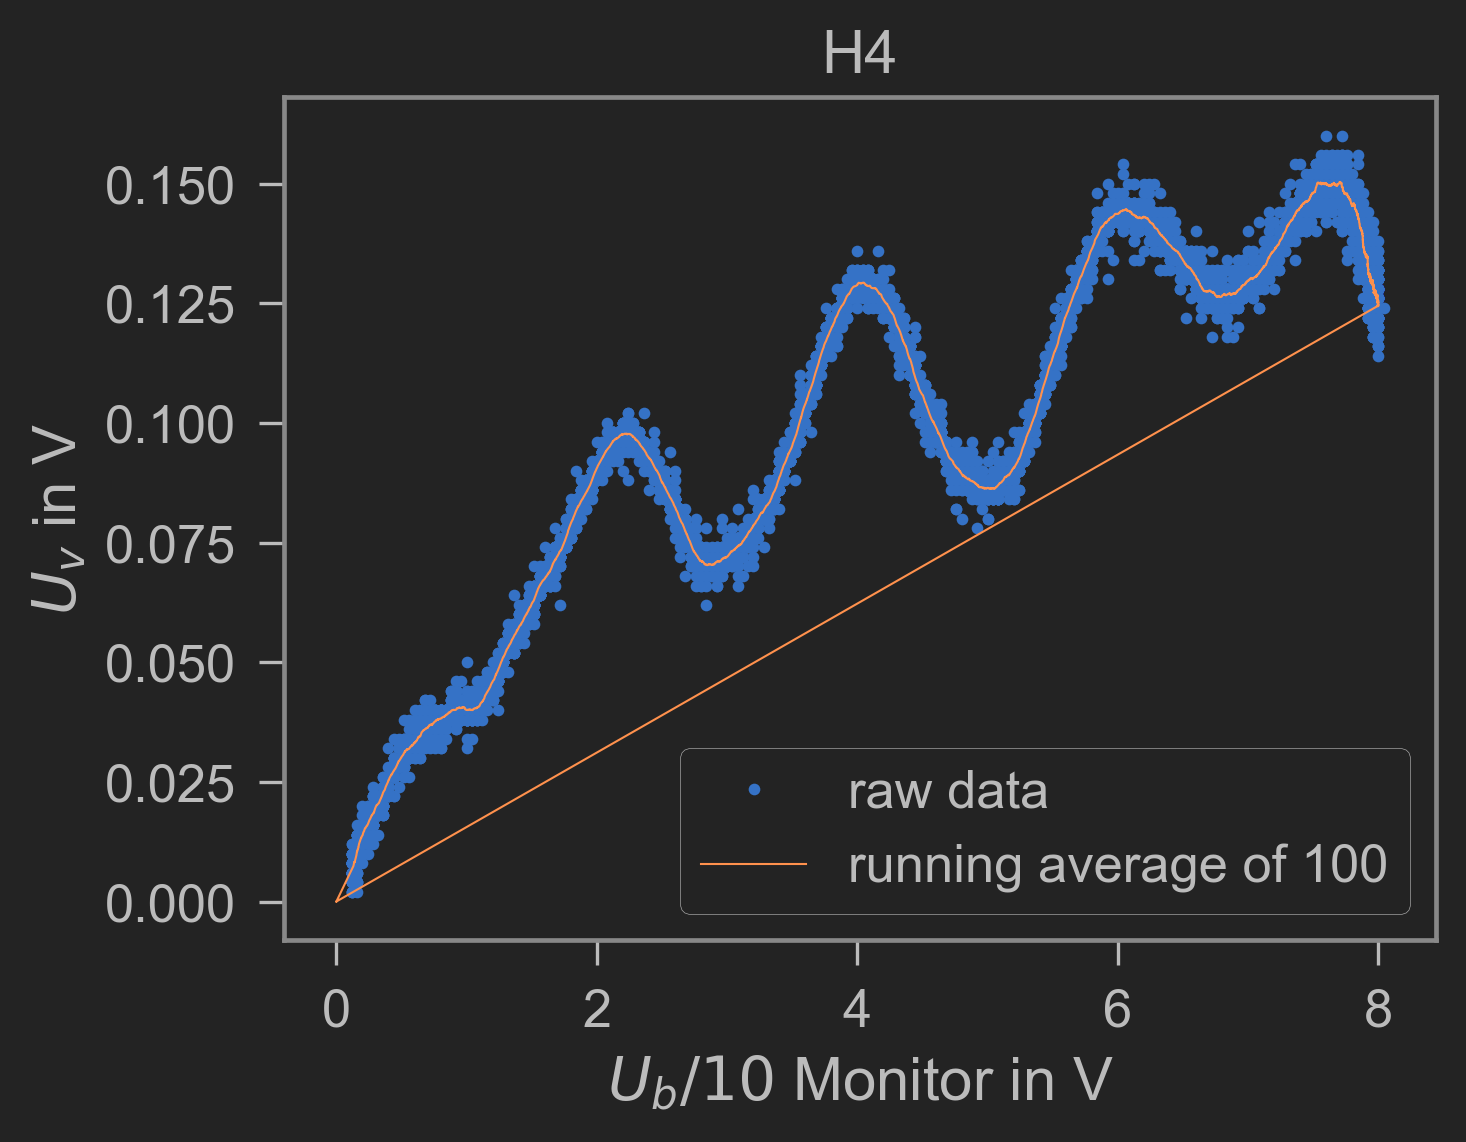

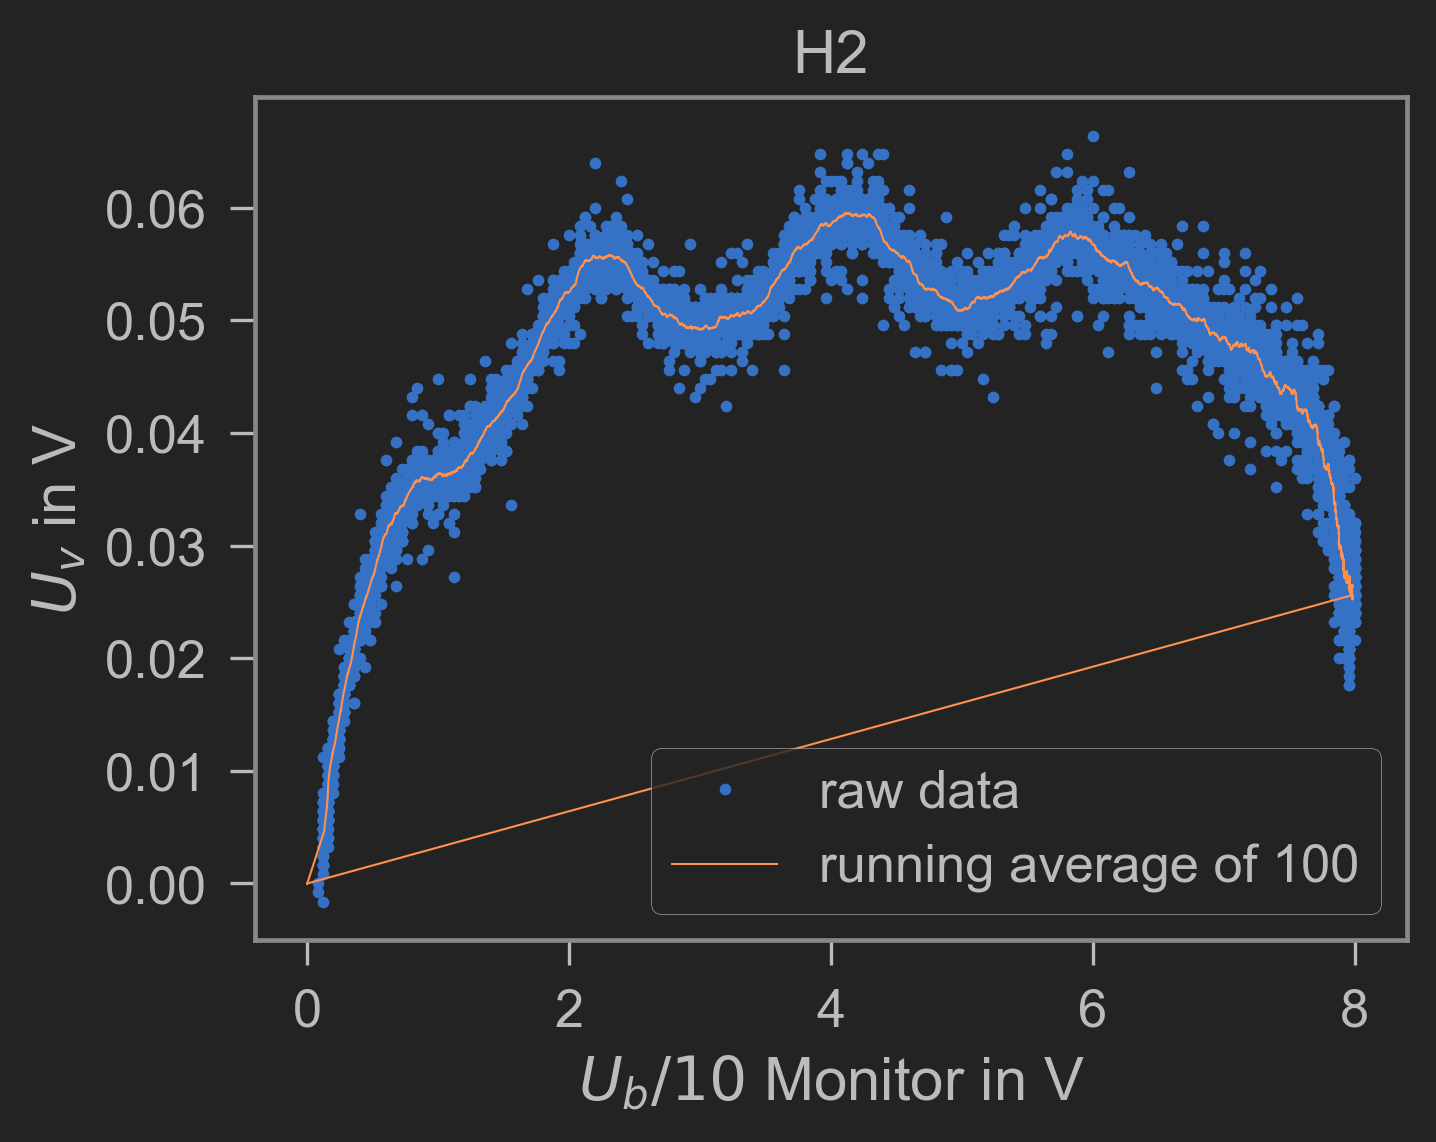

In [8]:
for name, df in data.items():
    plt.plot(df['U_b_1'], df['U_v_1'], 'b.', label = 'raw data')
    plt.plot(df['U_b_1_smooth'], df['U_v_1_smooth'], 'y-', linewidth = 0.5, label = 'running average of 100')

    plt.title(name)
    plt.xlabel('$U_b/10$ Monitor in V')
    plt.ylabel('$U_v$ in V')
    plt.legend()
    
    plt.show()

# Find Minima

## Helper functions

In [17]:
def parabola(x, x0, A, offset):
    return A*(x-x0)**2 + offset

def linear(x,a,b):
    return a*x + b

def find_local_minima(y, window_length, running_average_length = 1):
    y = running_average(y, running_average_length)
    
    minima_index = []
    for i in range(window_length, len(y)-window_length):
        is_min = False
        for j in range(-window_length, window_length):
            if y[i-j] < y[i]:
                is_min = False
                break
            else:
                is_min = True
                
        if is_min: minima_index.append(i)
    return minima_index

def fit_local_minima(ast_point, delta, x, y):
    popt, cov = curve_fit (parabola, x[ast_point-delta: ast_point + delta], y[ast_point-delta: ast_point + delta])
    return popt, cov

## Get data for minima

In [14]:
fit_length = 400

In [219]:
fff = open('fit_data_old.json', 'r')
fff_s = fff.read()
fff.close()
fit_data_old = json.loads(fff_s)#cycle through all measurements and find all minima

fit_data = {}
for name, df in data.items():
#for name, df in {'G4V': data['G4V'], 'H4': data['H4'], 'H7': data['H7']}.items():
    #estimate index of minimum in smoothed data
    
    #run this if there is no json
    '''if name == 'H7':
        minima_index = [3627, 6466, 9600]

    elif name == 'G4V':
        minima_index = [3627, 6400, 9400]

    elif name == 'H4':
        minima_index = [3800, 6650, 9600]
    
    else:
        minima_index = find_local_minima(df['U_v_1_smooth'], 300)
    '''

    #delete if there is no json
    minima_index = [d['index'] for d in fit_data_old[name]]
    
    #create entries for every measurement
    fit_data[name] = []
    
    max_number = min(3, len(minima_index))
    for i in range(max_number):
        
        #fit parabola around estimated minimum
        x = np.array(df['U_b_1'])
        y = np.array(df['U_v_1'])
        params, cov = fit_local_minima(minima_index[i], fit_length, x, y)
        
        #write dictionary with fit parameters
        fit_data[name].append({})
        
        fit_data[name][i]['min_number'] = i+1

        fit_data[name][i]['index'] = minima_index[i]
        
        fit_data[name][i]['value'] = {}
        fit_data[name][i]['value']['x'] = df['U_b_1_smooth'][minima_index[i]]
        fit_data[name][i]['value']['y'] = df['U_v_1_smooth'][minima_index[i]]
        
        fit_data[name][i]['fit_value'] = {}
        fit_data[name][i]['fit_value']['x'] = params[0]
        fit_data[name][i]['fit_value']['y'] = params[2]

        fit_data[name][i]['fit_value_err'] = {}
        fit_data[name][i]['fit_value_err']['x'] = np.sqrt(cov[0][0])
        fit_data[name][i]['fit_value_err']['y'] = np.sqrt(cov[2][2])
        
        fit_data[name][i]['fit_params'] = {}
        fit_data[name][i]['fit_params']['A'] = params[1]
        fit_data[name][i]['fit_params']['x_0'] = params[0]
        fit_data[name][i]['fit_params']['c'] = params[2]
        
        #fit_data[name][i]['cov'] = cov
        
        fit_data[name][i]['fit_params_err'] = {}
        fit_data[name][i]['fit_params_err']['A'] = np.sqrt(cov[1][1])
        fit_data[name][i]['fit_params_err']['x_0'] = np.sqrt(cov[0][0])
        fit_data[name][i]['fit_params_err']['c'] = np.sqrt(cov[2][2])
        
        fit_data[name][i]['delta'] = {}
        fit_data[name][i]['delta_err'] = {}
        if i == 0:
            fit_data[name][i]['delta'] = 0
            fit_data[name][i]['delta_err'] = 0
        else:
            delta = ufloat(fit_data[name][i]['fit_value']['x'], fit_data[name][i]['fit_value_err']['x']) - ufloat(fit_data[name][i-1]['fit_value']['x'], fit_data[name][i-1]['fit_value_err']['x'])
            fit_data[name][i]['delta'] = delta.nominal_value
            fit_data[name][i]['delta_err'] = delta.std_dev

In [95]:
#save data in json file to check it later
with open('fit_data.json', 'w', encoding = 'utf-8') as f:
    s = json.dumps(fit_data, indent = 4, separators = (',', ': '))
    f.write(s)

In [10]:
#retrieve fit data
fff = open('fit_data_old.json', 'r')
fff_s = fff.read()
fff.close()
fit_data = json.loads(fff_s)

## Plot minima

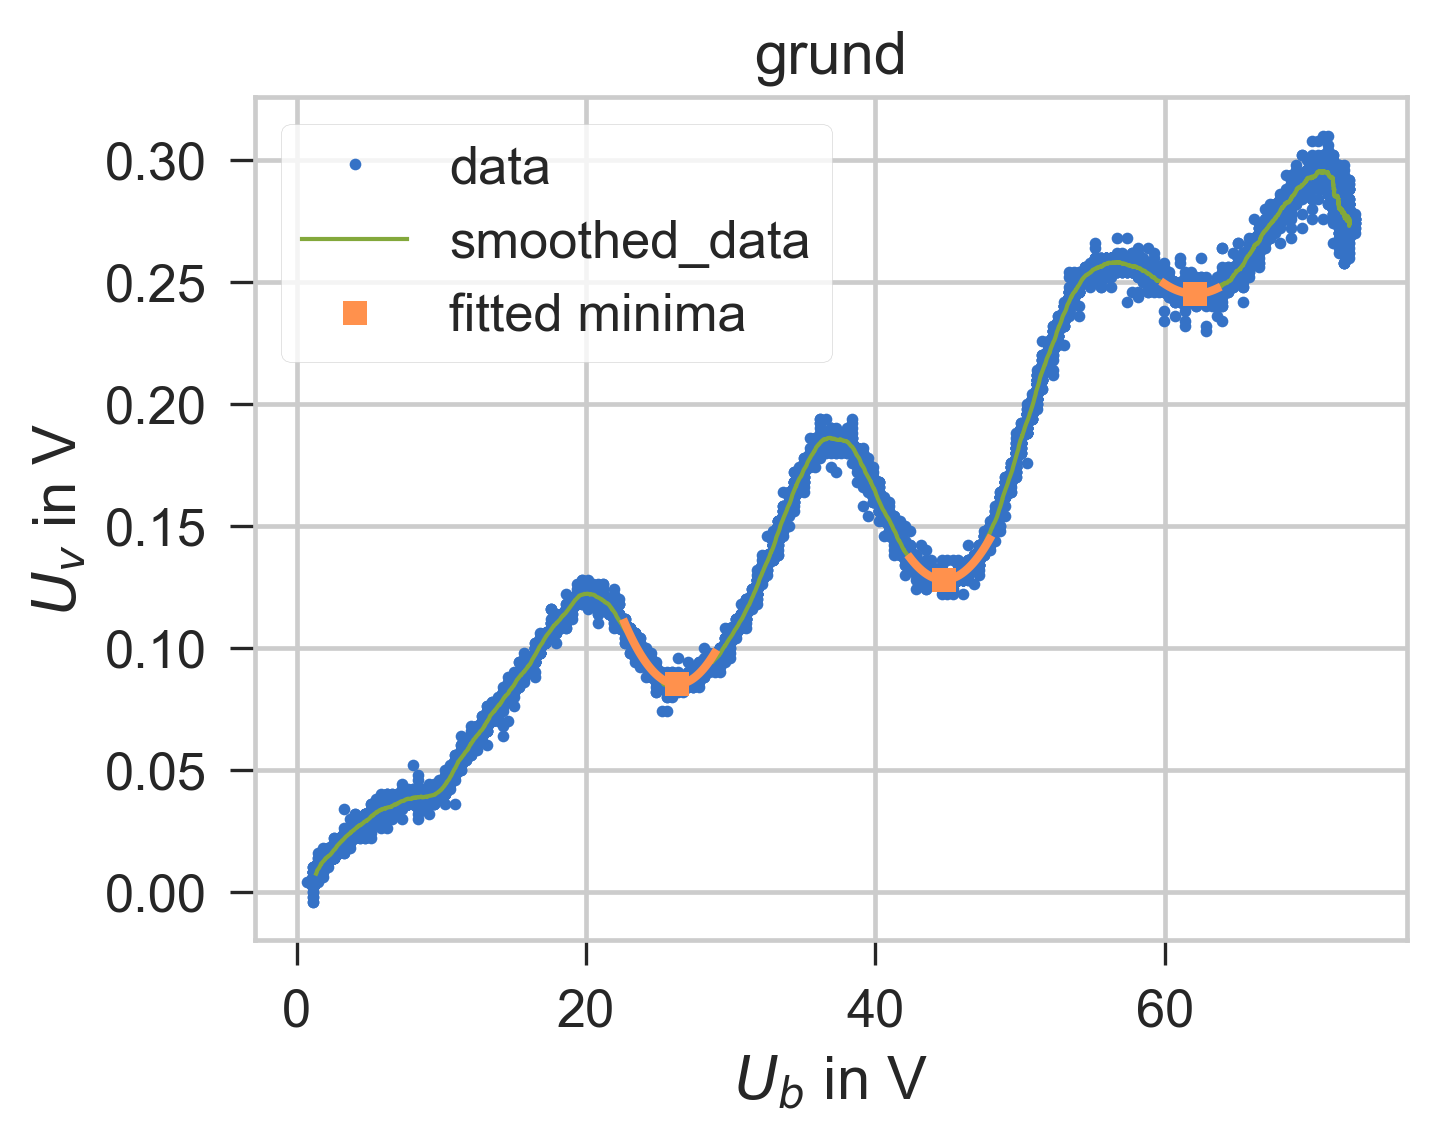

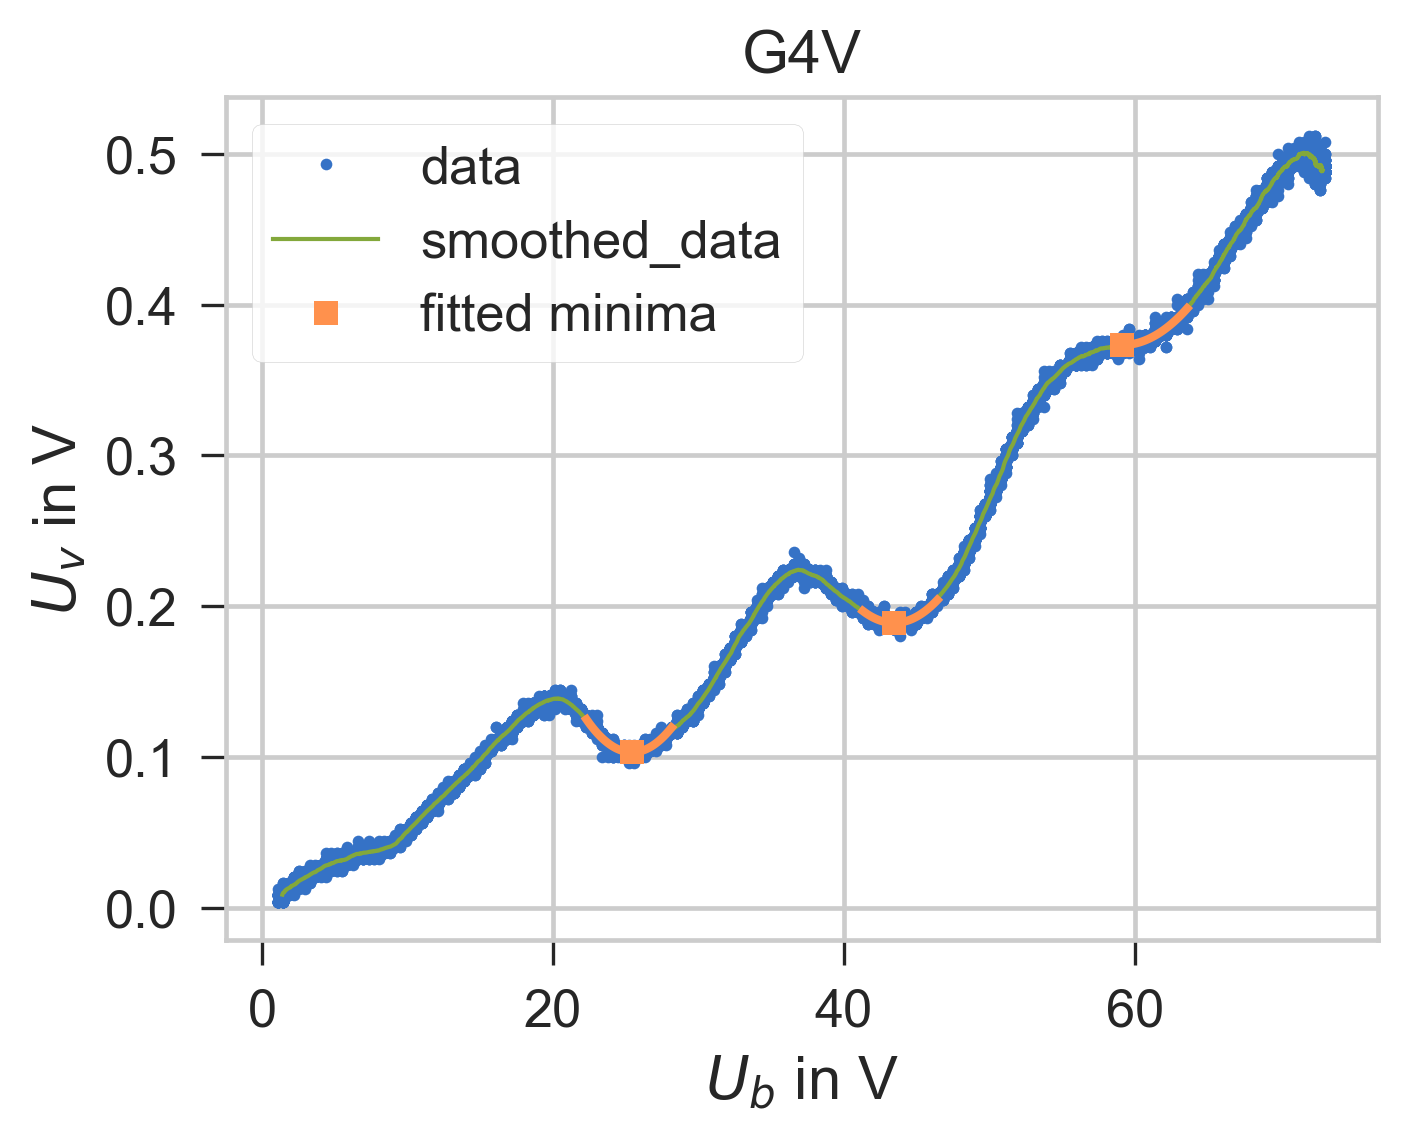

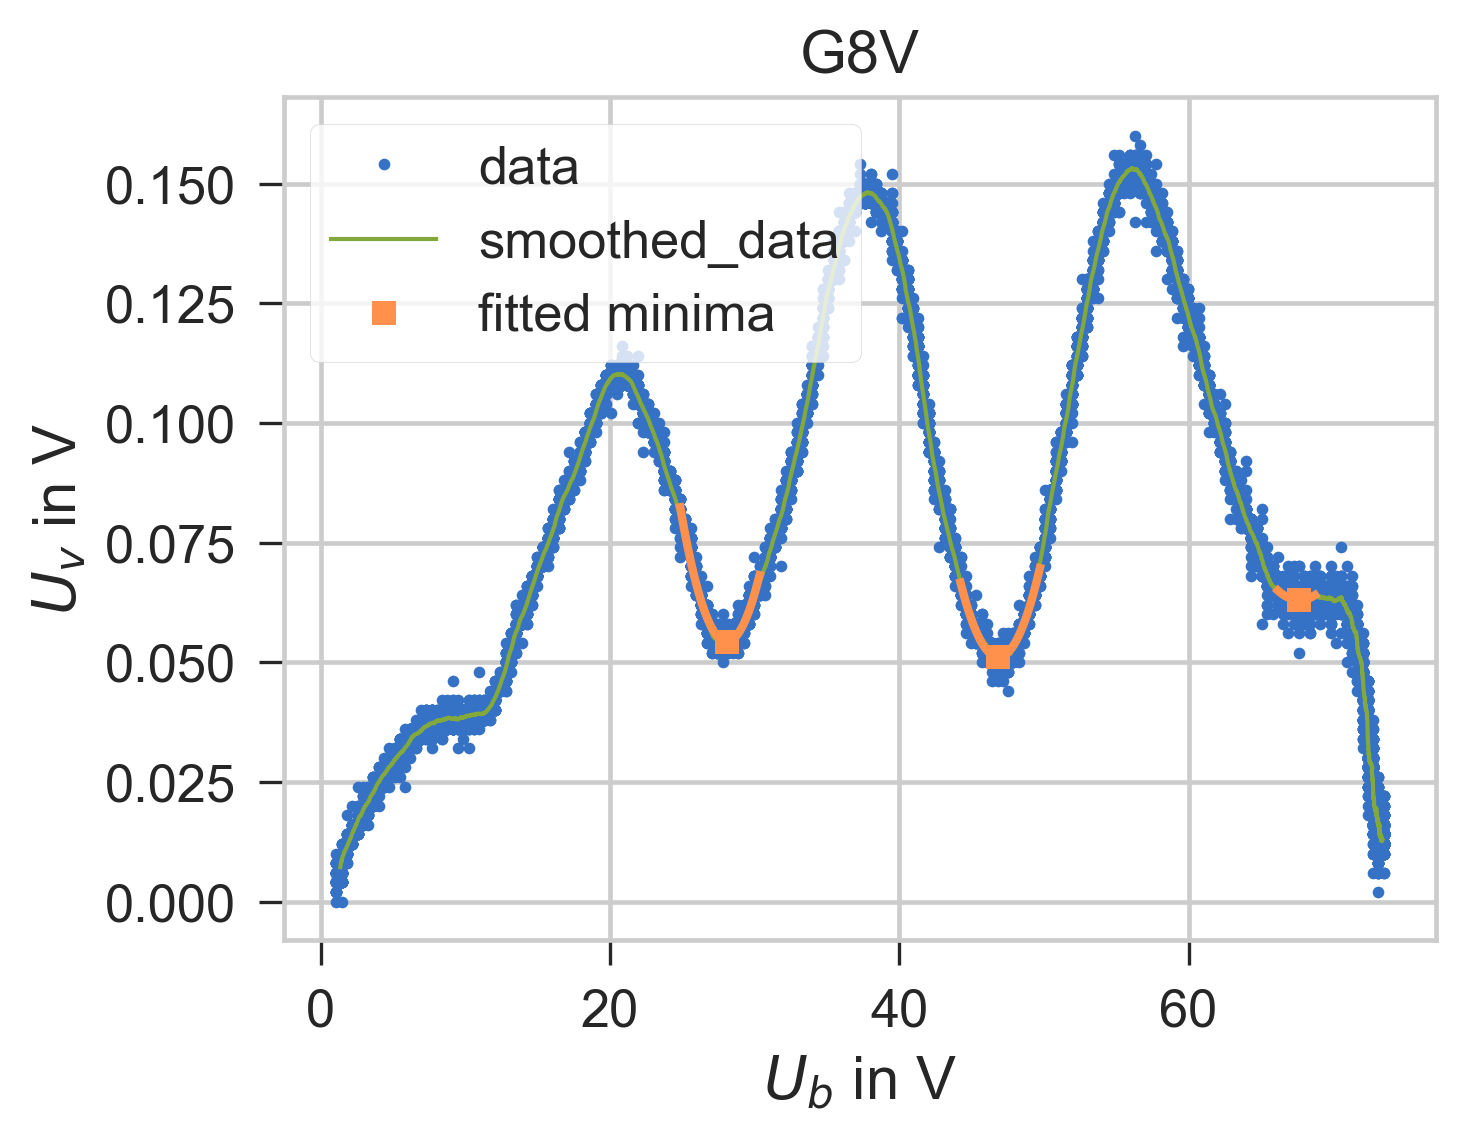

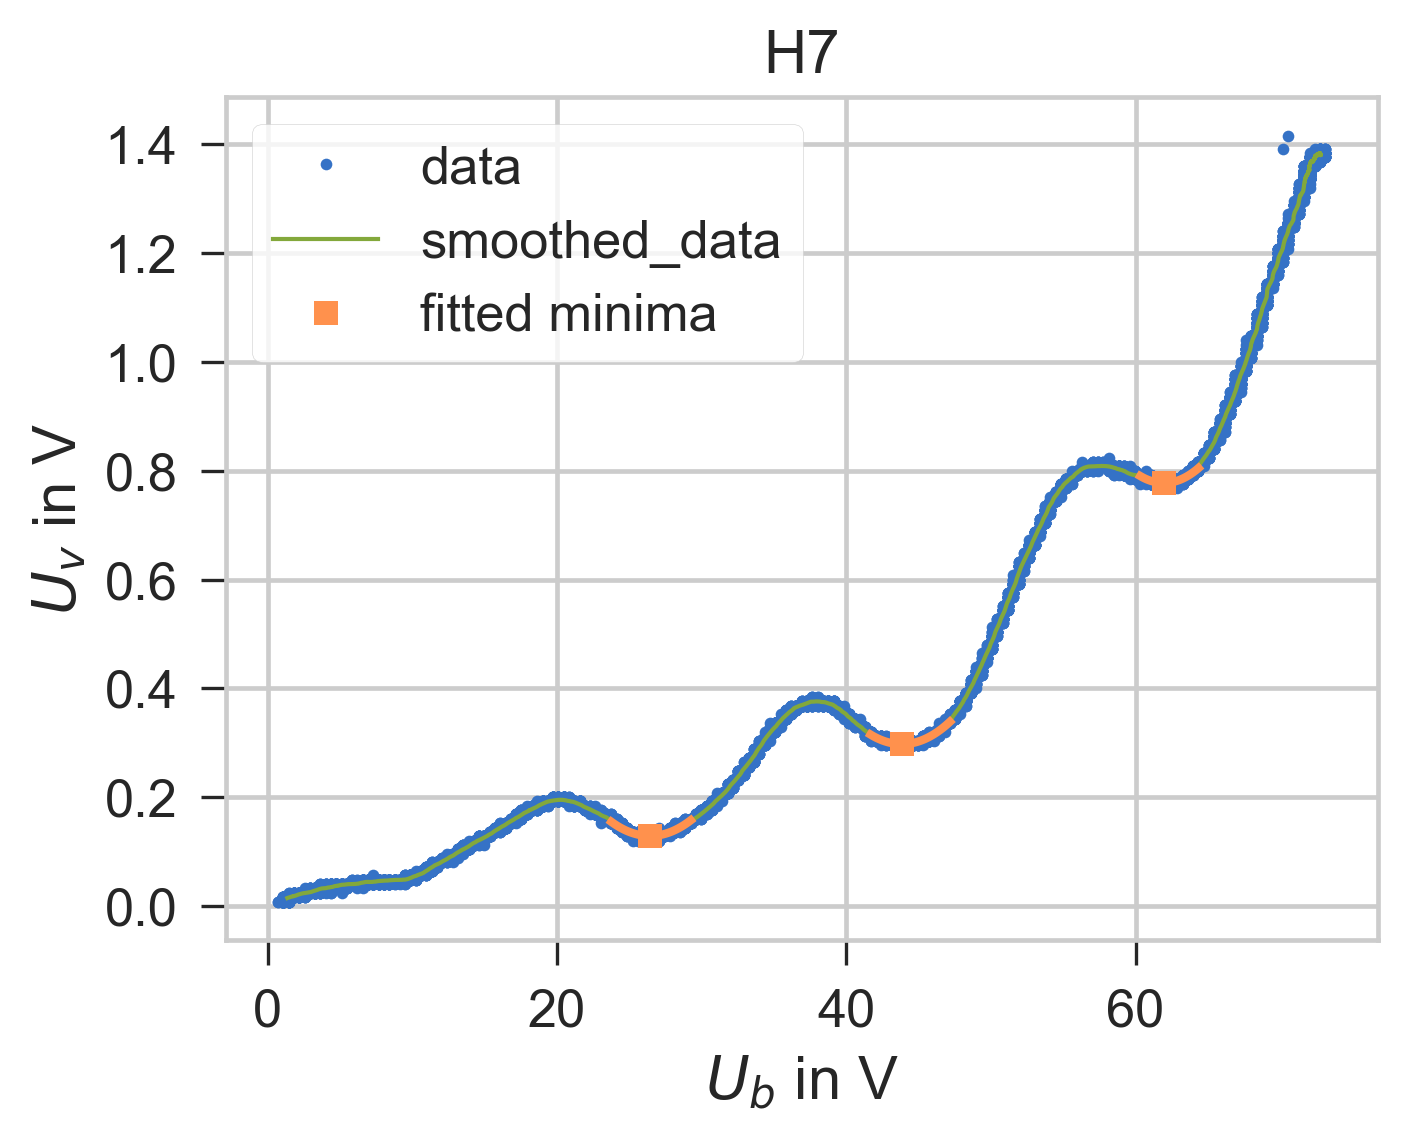

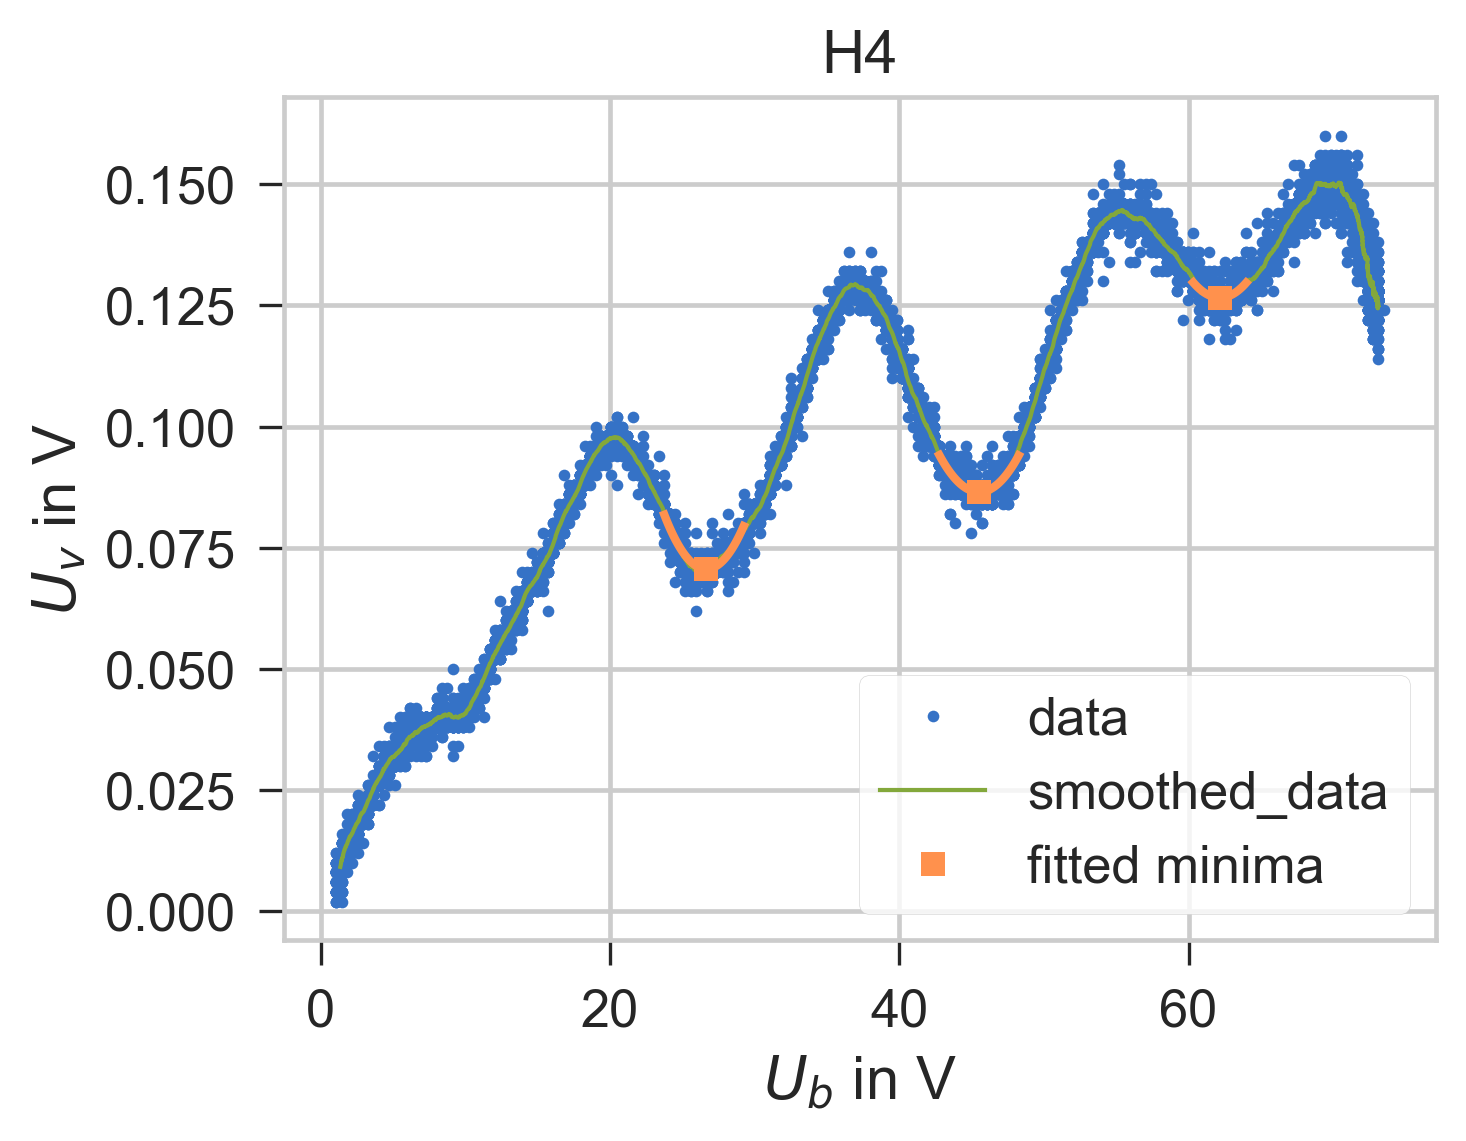

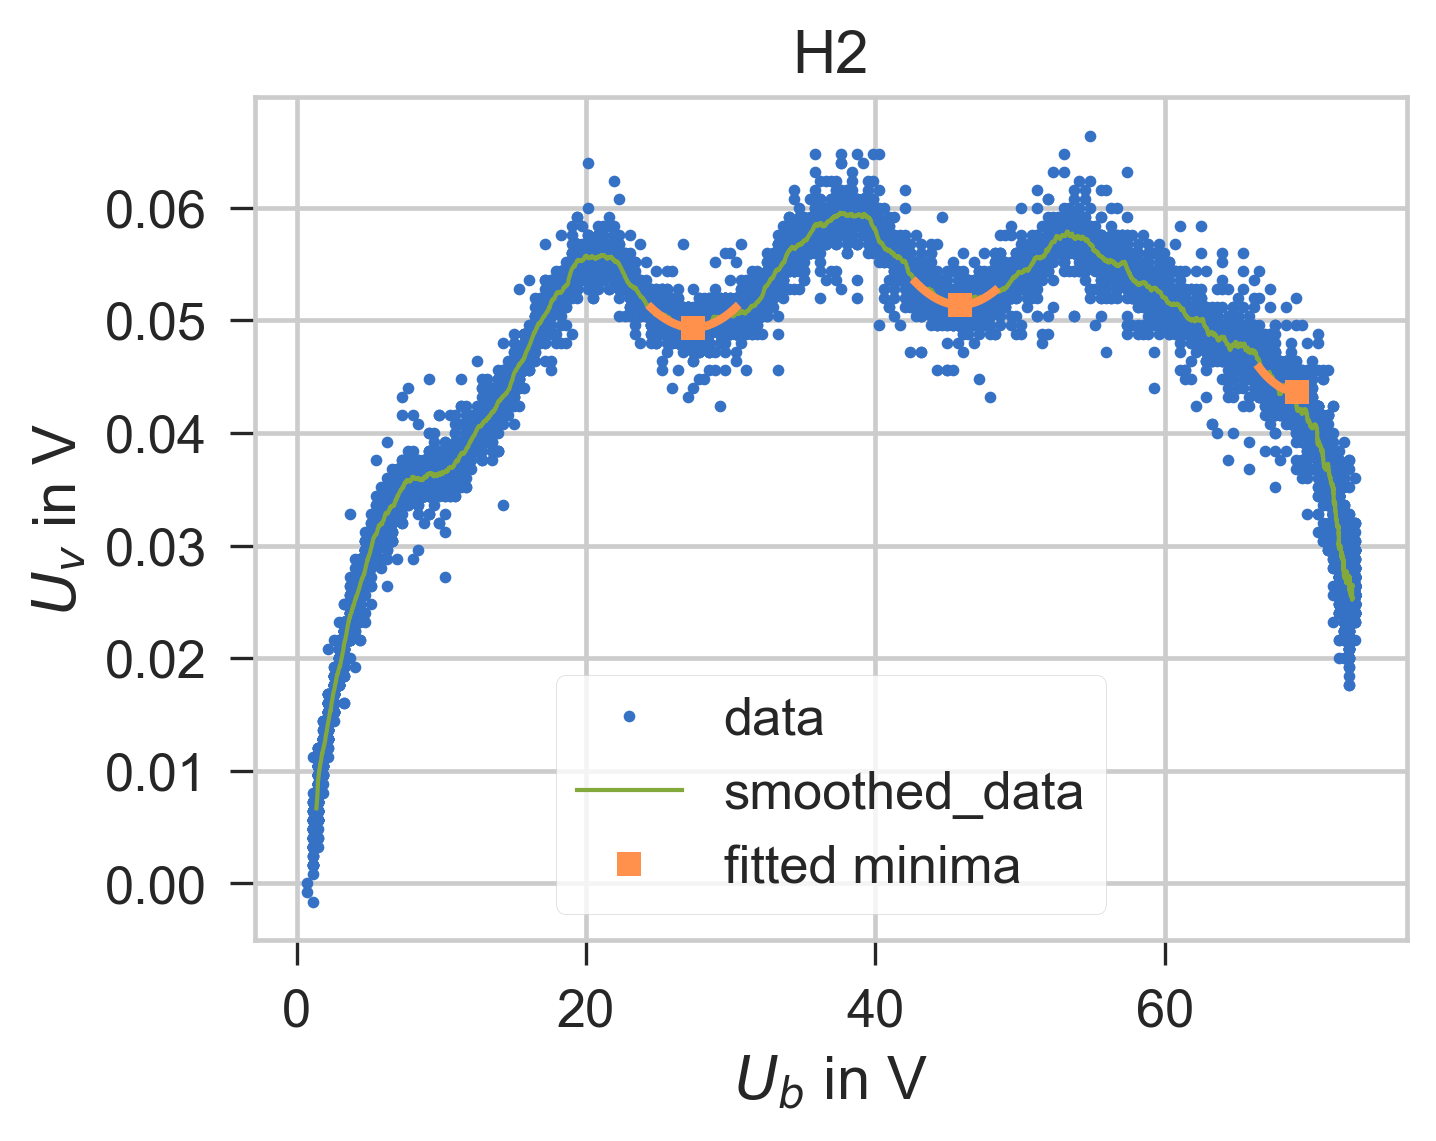

In [15]:
lp()
umrechnung = 9.14
#loop through measurements
#for (name, df) in [('G4V', df_G4V)]:
for (name, df) in data.items():
    plt.plot(df['U_b_1']*umrechnung, df['U_v_1'], 'b.', label = 'data')
    plt.plot(df['U_b_1_smooth'][100:-100]*umrechnung, df['U_v_1_smooth'][100:-100], 'g-', linewidth = 1, label = 'smoothed_data')
    
    #loop through minima
    for i in range(len(fit_data[name])):
        #plot estimated and fitted minima
        #plt.plot(fit_data[name][i]['value']['x']*umrechnung, fit_data[name][i]['value']['y'], 'gs')
        plt.plot(fit_data[name][i]['fit_value']['x']*umrechnung, fit_data[name][i]['fit_value']['y'], 'ys')
        
        #plot fit approximation around minima
        minimum_index  =  fit_data[name][i]['index']
        x = np.linspace(df['U_b_1'][minimum_index-fit_length], df['U_b_1'][minimum_index+fit_length], 100)*umrechnung
        
        popt = [fit_data[name][i]['fit_params']['x_0']*umrechnung, fit_data[name][i]['fit_params']['A']/umrechnung**2, fit_data[name][i]['fit_params']['c']]
        plt.plot(x, parabola(x, *popt), 'y-', linewidth = 2)
    
    #plt.plot([], [], 'gs', label = 'estimated minima')
    plt.plot([], [], 'ys', label = 'fitted minima')
    #plt.plot([], [], 'y-', label = 'fit approximation')

    plt.xlabel('$U_b$ in V')
    plt.ylabel('$U_v$ in V')
    
    if name == 'G8V':
        plt.legend(loc = 'upper left')
    else:
        plt.legend()
    
    plt.savefig(f'Plots/Kennlinien/minima_{name}')

    plt.grid()
    plt.title(name)
    plt.show()

## Get manual indices for dummzeug

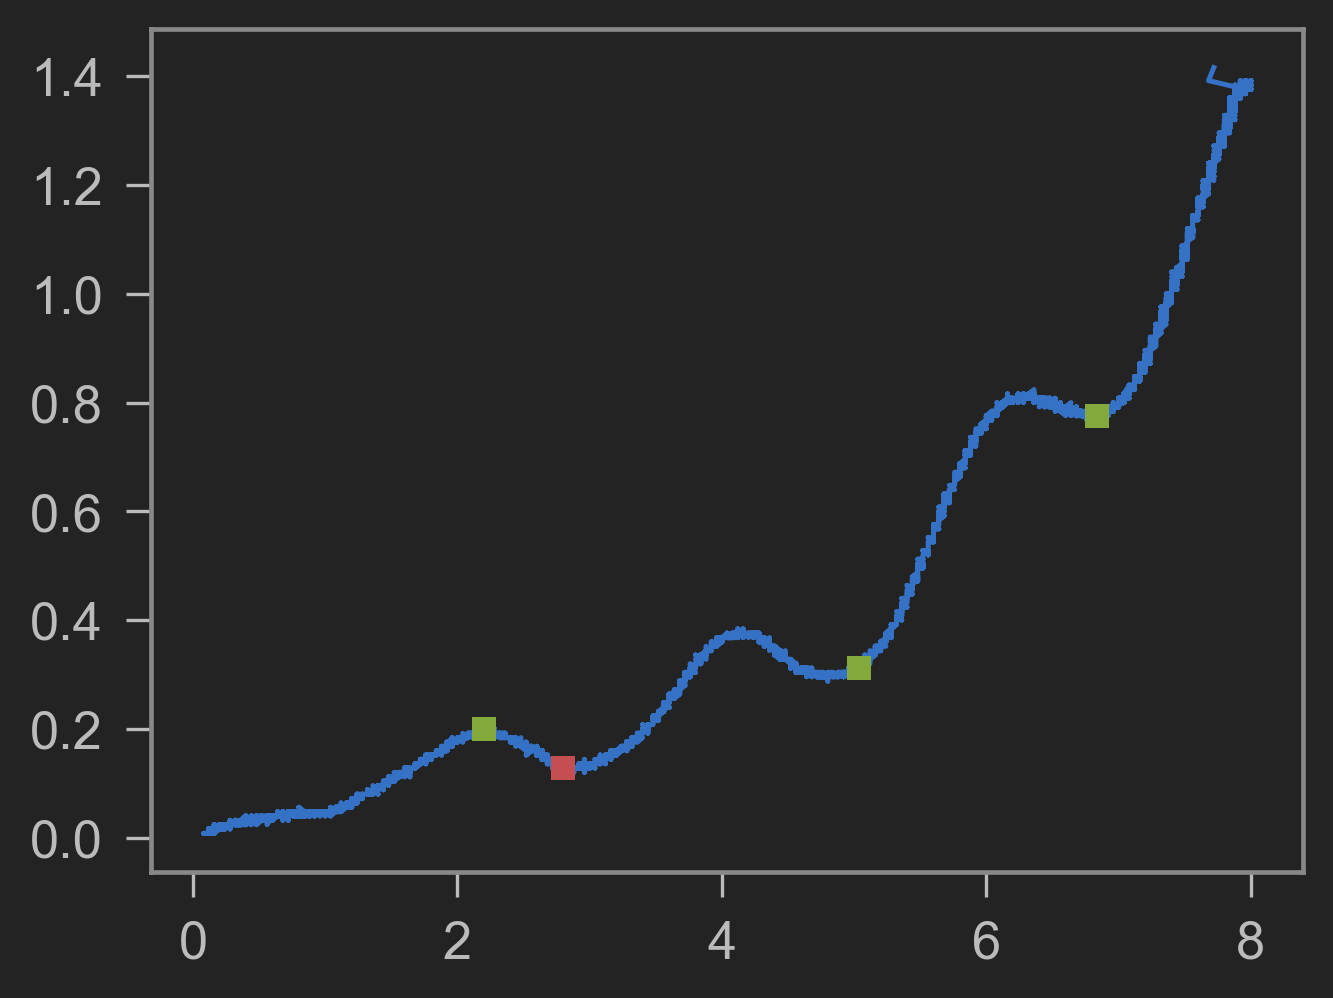

In [29]:
dp()
name = 'H7'
plt.plot(data[name]['U_b_1'], data[name]['U_v_1'])

#minima
for m in [3627, 6700, 9600]:
    plt.plot(data[name]['U_b_1'][m], data[name]['U_v_1'][m], 'rs')

#maxima
for m in [2900, 6700, 9600]:
    plt.plot(data[name]['U_b_1'][m], data[name]['U_v_1'][m], 'gs')

## Calculate E_a

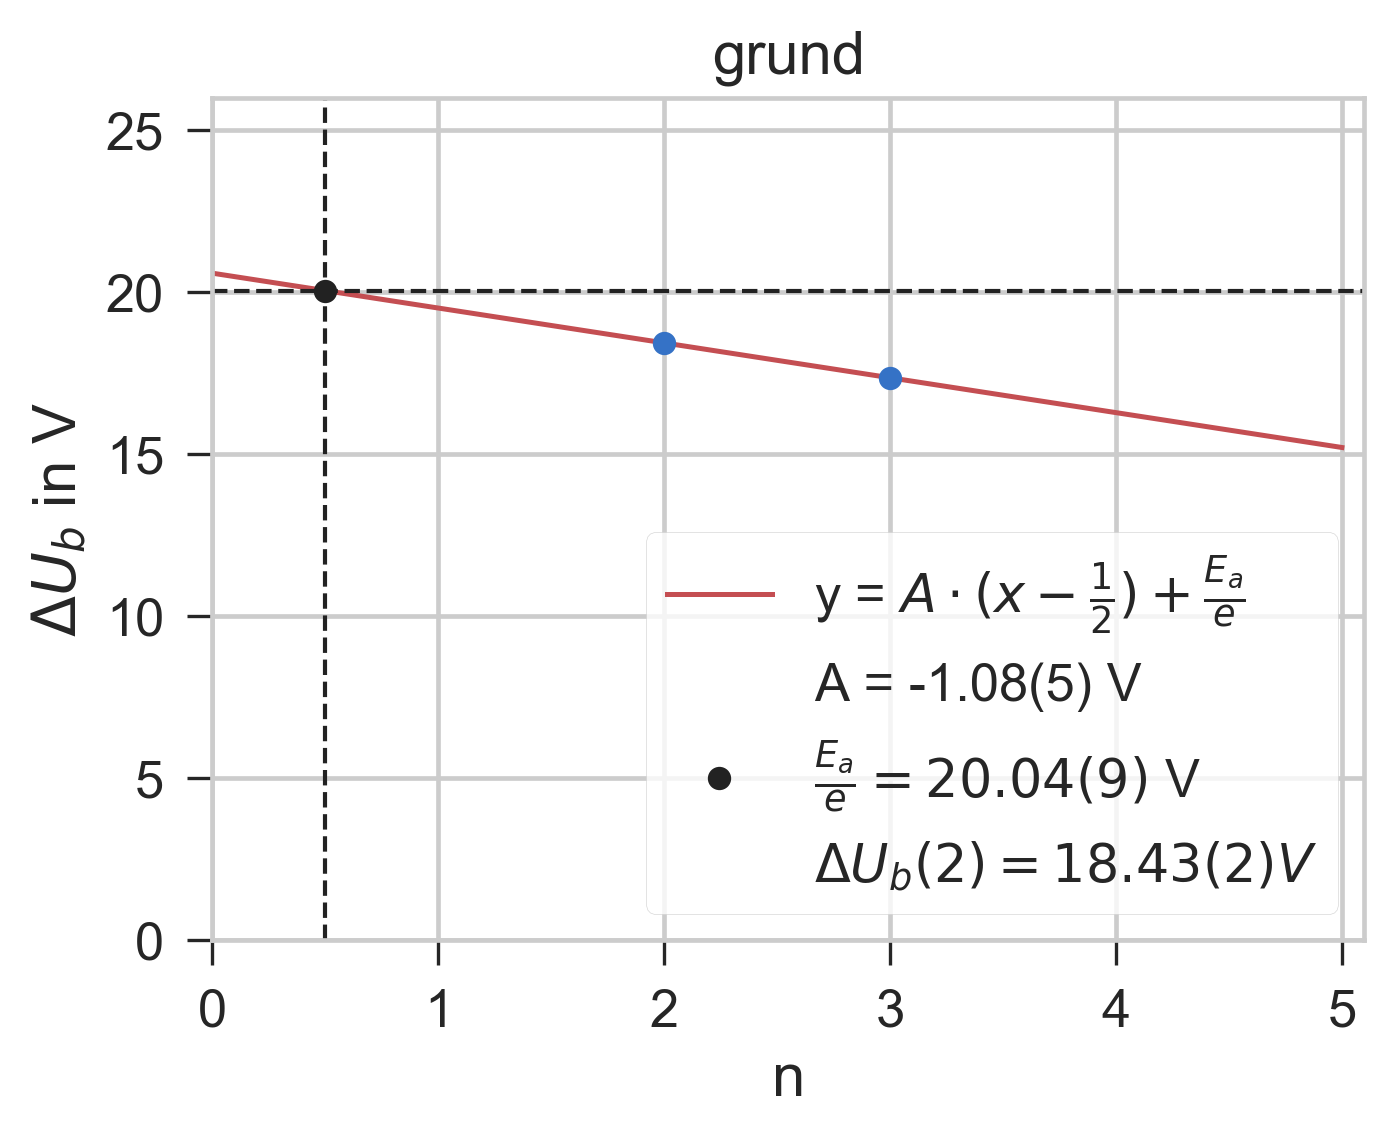

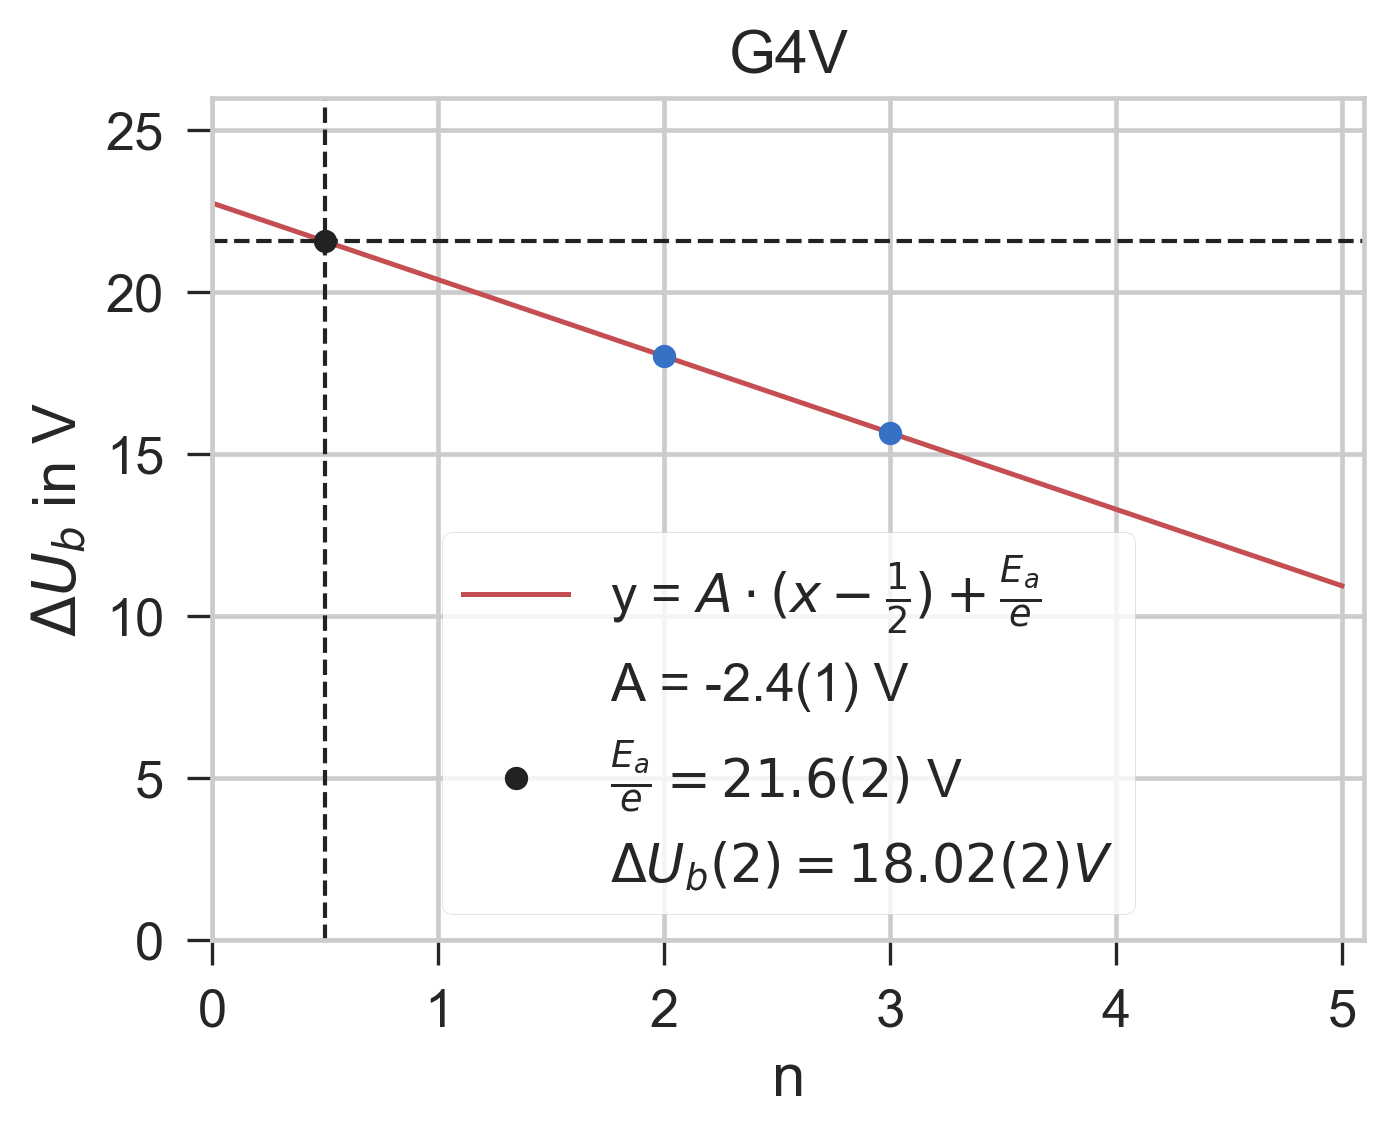

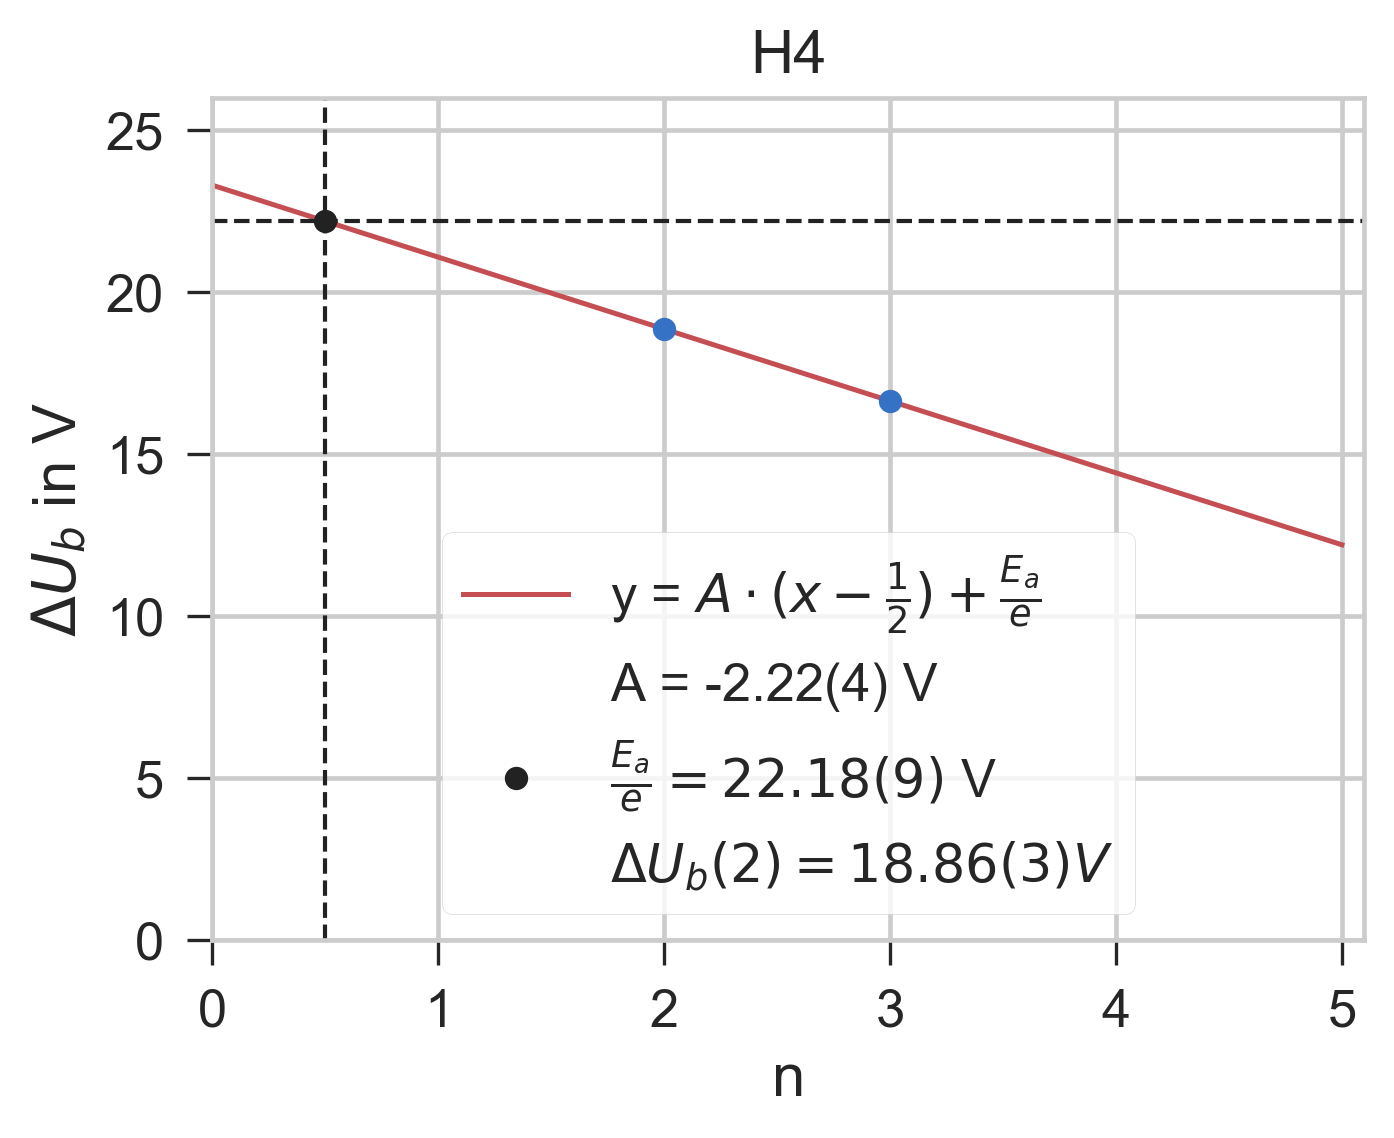

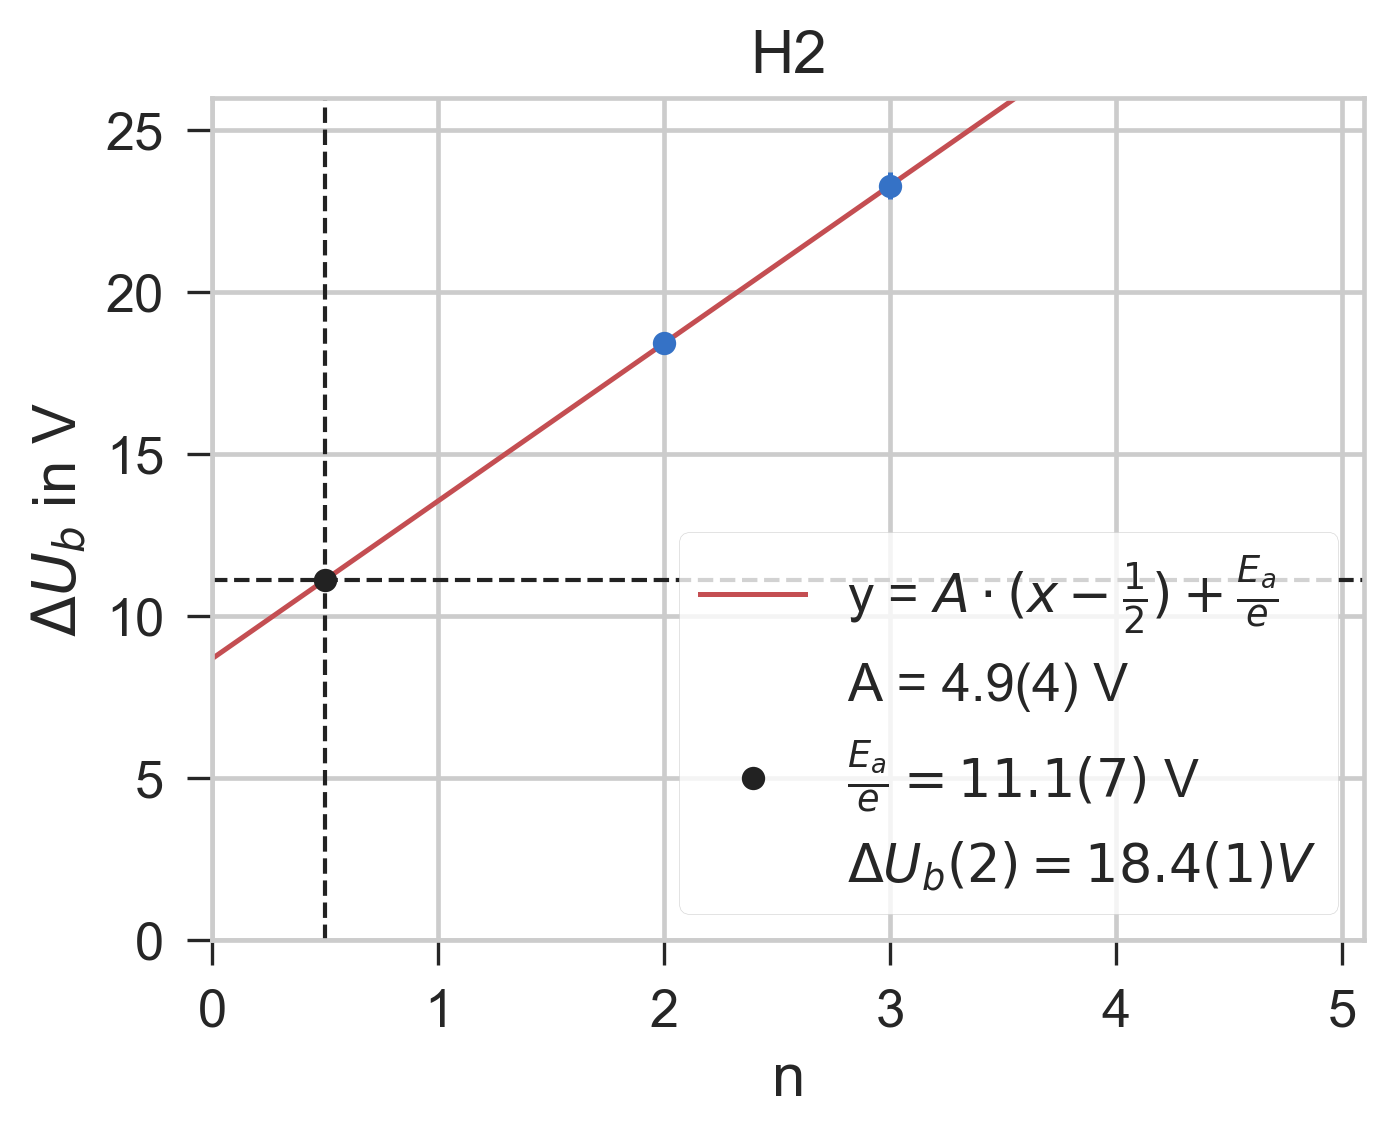

In [52]:
lp()
from scipy.constants import e as electron_charge

def linear_offset(x,a,b):
    return a*(x-0.5) + b

for name, df in data.items():

    deltas = np.array([fit_data[name][1]['delta'], fit_data[name][2]['delta']])*umrechnung
    deltas_err = np.array([fit_data[name][1]['delta_err'], fit_data[name][2]['delta_err']])*umrechnung
    n = [2,3]
    
    popt, cov = curve_fit(linear_offset, n, deltas, sigma = deltas_err, absolute_sigma= True)
    
    #E_a = linear_offset(0, *popt)
    E_a = popt[1]
    
    a = ufloat(popt[0], np.sqrt(cov[0][0]))
    b = ufloat(popt[1], np.sqrt(cov[1][1]))

    l_L = popt[0]*electron_charge/(2*E_a)

    fit_data[name][0]['E_a'] = b.nominal_value
    fit_data[name][0]['E_a_err'] = b.std_dev
    fit_data[name][0]['lambda/L'] = l_L
    
    #plot data
    plt.errorbar(n, deltas, yerr = deltas_err, fmt = 'bo', capsize = 2)

    # plot fit line
    x = np.linspace(0,5,2)
    plt.plot(x, linear_offset(x, *popt), 'r-', label = r'y = $A\cdot (x-\frac{{1}}{{2}}) + \frac{{E_a}}{{e}}$')
    plt.plot([],[], ' ', label = fmtr.format('A = {:.1u} V', a))
    plt.plot([0.5],[b.nominal_value], 'ko', label = fmtr.format(r'$\frac{{E_a}}{{e}} = {:.1u}$ V', b), linewidth = 0.3)
    
    #plot black lines
    plt.plot([0.5,0.5],[0,50], 'k--', linewidth = 1)
    plt.plot([0,10],[b.nominal_value, b.nominal_value], 'k--', linewidth = 1)

    #represent mean value
    plt.plot([],[], ' ', label = fmtr.format('$ΔU_b(2) = {:.1u} V$', ufloat(deltas[0], deltas_err[0])))

    plt.xlabel('n')
    plt.ylabel('$ΔU_b$ in V')
    
    plt.xlim(0, 5.1)
    plt.ylim(0, 26)
    plt.legend()

    plt.savefig(f'Plots/Deltas/deltas_{name}')
    
    plt.title(name)
    plt.grid()
    plt.show()

In [51]:
cov[0][1]/(np.sqrt(cov[0][0]*cov[1][1]))

-0.9891928913987296

## Write latex table

In [86]:
#d = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}

for name in fit_data:
    d[name] = {}
    deltas = []
    for m in range(1,len(fit_data[name])):
        delta = ufloat(fit_data[name][m]['fit_value']['x'], fit_data[name][m]['fit_value_err']['x']) - ufloat(fit_data[name][m-1]['fit_value']['x'], fit_data[name][m-1]['fit_value_err']['x'])
        deltas.append(fmtr.format('{:.1u}', delta))
        
        #delta_0 = fit_data[name][m]['value']['x'] - fit_data[name][m-1]['value']['x']
        
        print(f'{name}: delta fit U_{m+2}, {delta*9.14}')
        #print(f'{name}: delta fit U_{m+2}, {delta_0*ufloat(9.14,0.01)}')


grund: delta fit U_3, 18.429+/-0.022
grund: delta fit U_4, 17.35+/-0.05
G4V: delta fit U_3, 18.018+/-0.020
G4V: delta fit U_4, 15.66+/-0.13
G8V: delta fit U_3, 18.778+/-0.013
G8V: delta fit U_4, 20.80+/-0.04
H7: delta fit U_3, 17.412+/-0.017
H7: delta fit U_4, 18.108+/-0.020
H4: delta fit U_3, 18.856+/-0.027
H4: delta fit U_4, 16.637+/-0.035
H2: delta fit U_3, 18.42+/-0.10
H2: delta fit U_4, 23.3+/-0.4


In [184]:
d = {}
fmtr = ShorthandFormatter()

kalibrierung = ufloat(9.14, 0.01)

for name in fit_data:
    d[name] = {}
    d_u3 = ufloat(fit_data[name][1]['delta'], fit_data[name][1]['delta_err'])*kalibrierung
    d_u4 = ufloat(fit_data[name][2]['delta'], fit_data[name][2]['delta_err'])*kalibrierung
    d[name]['Delta U(3)'] = fmtr.format('{:.1u}', d_u3)
    d[name]['Delta_U(4)'] = fmtr.format('{:.1u}', d_u4)
    d[name]['Delta U m'] = fmtr.format('{:.1u}', 0.5*(d_u3 + d_u4))
    d[name]['E_a'] = '{:.1f}'.format(fit_data[name][0]['E_a'])
    #d[name]['$\frac{lambda}{L}$'] = '{:.1f}'.format(fit_data[name][0]['lambda/L'])

tab = pd.DataFrame(d)
s = tab.to_latex(decimal = ',', header = ['1','2','3','4','5','6'], index = ['aaa', 'bbb'])

f = open('table.txt', 'w')
f.write(s)
f.close()

tab

grund       G4V       G8V        H7        H4       H2
Delta U(3)  18.43(3)  18.02(3)  18.78(2)  17.41(3)  18.86(3)  18.4(1)
Delta_U(4)  17.35(5)   15.7(1)  20.80(5)  18.11(3)  16.64(4)  23.3(4)
Delta U m   17.89(3)  16.84(7)  19.79(3)  17.76(2)  17.75(3)  20.9(2)
E_a             21.1      23.9      13.7      15.7      24.4      6.3

# Calibration

## Calculation

c:\users\calva\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
c:\users\calva\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


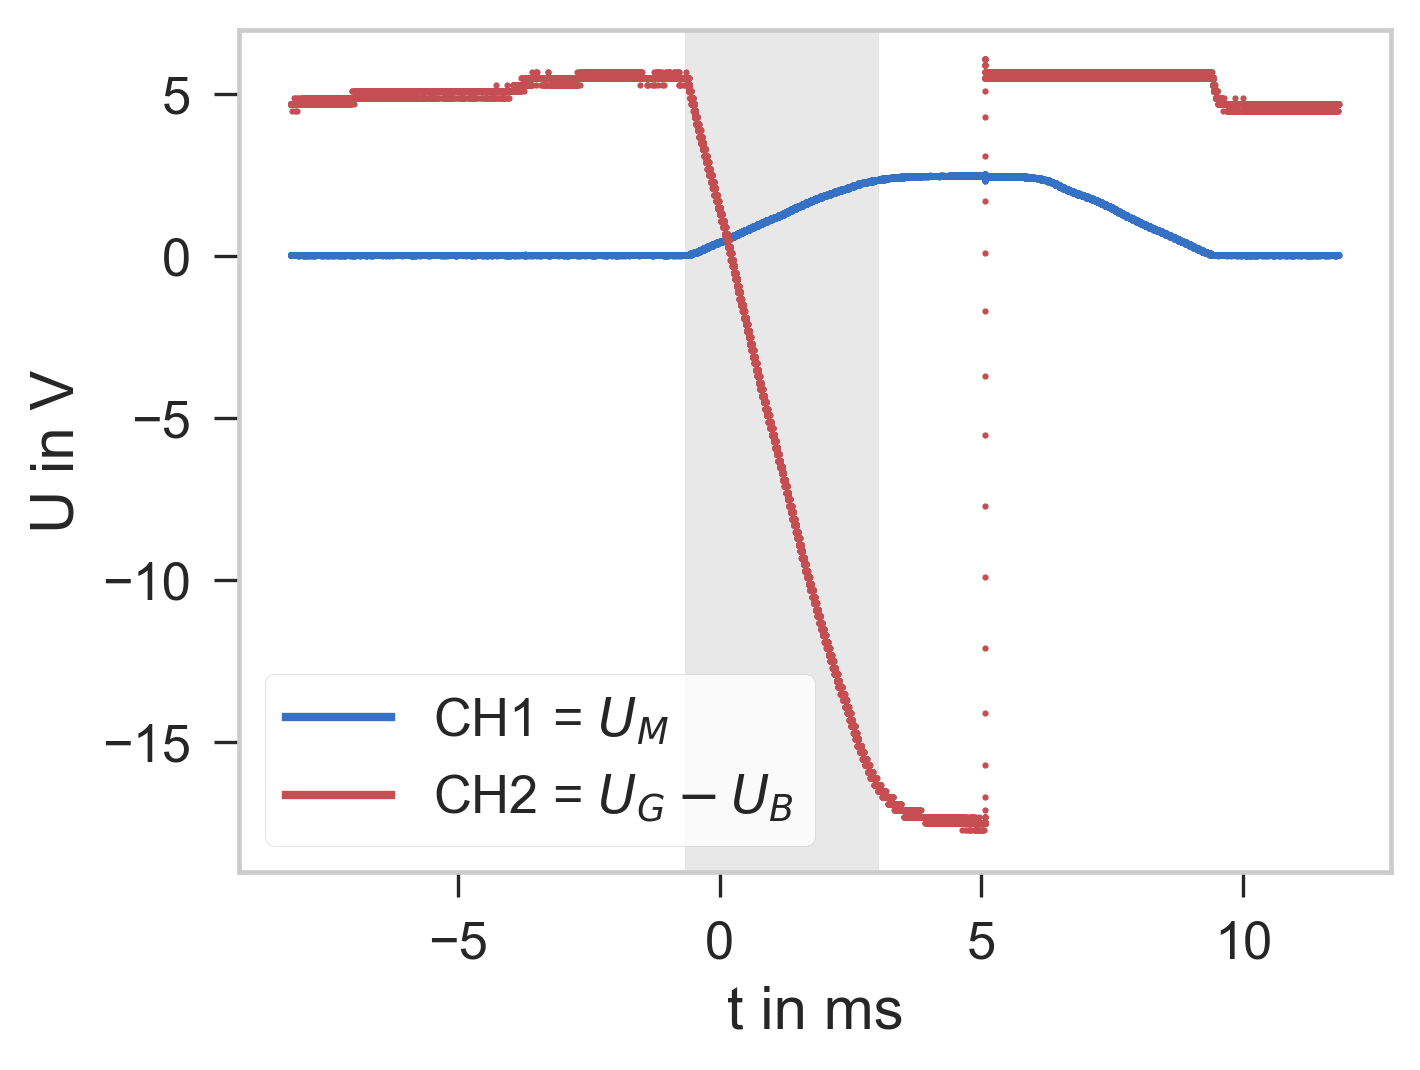

In [47]:
lp()
df_c = pd.read_csv('Oszilloskop/T0007.CSV', header = 14)

plt.plot(1000*df_c['TIME'], df_c['CH1'], 'b.', markersize = 3)
plt.plot(1000*df_c['TIME'], df_c['CH2'], 'r.', markersize = 3)

start = 47000
end = 70000

plt.fill_between([1000*df_c['TIME'][start],1000*df_c['TIME'][end]],[9,9], y2 = [-20,-20], alpha = 0.1, color = 'k')

custom_lines = [Line2D([0], [0], color='b', lw=2, label = 'CH1 = $U_M$'), Line2D([0], [0], color='r', lw=2,  label = 'CH2 = $U_G - U_B$')]

plt.xlabel('t in ms')
plt.ylabel('U in V')

plt.ylim(-19,7)

plt.legend(handles = custom_lines)

plt.savefig('Plots/kalibrierung_daten')

plt.show()

In [67]:
lp()

fmtr = ShorthandFormatter()

df_c = pd.read_csv('Oszilloskop/T0007.CSV', header = 14)
#df_c = format_dataframe(df_c, jump_th = 0.04, running_average_length = 1)

df_c = df_c.rename(columns = {'CH1': 'U_b_1', 'CH2': 'U_v_1'})

u_b = df_c['U_b_1']
u_v = df_c['U_v_1']

popt, cov = curve_fit(linear, u_b[start:end], u_v[start:end])

x = np.linspace(u_b[start], u_b[end], 2)

a = ufloat(popt[0], cov[0][0])
b = ufloat(popt[1], cov[1][1])

plt.plot(u_b[start:end], u_v[start:end], '.', color = 'y', label = 'Datenpunkte', markersize = 3)
plt.plot(x, linear(x,*popt), '-', color = 'blue', label = 'fitgerade $y = a\cdot x + b$')
plt.plot([], [], ' ', label = fmtr.format('a = {:.1u}, b = {:.1u}', a, b))

plt.xlabel('$U_M$')
plt.ylabel('$U_B$')
plt.legend(loc = 'lower left')

plt.savefig('Plots/kalibrierung_kennlinie')

plt.show()

In [2]:
plt.close('all')

In [23]:
from scipy.constants import elementary_charge as e

A = ufloat(0.7, 0.03)
E_a = ufloat(16.37, 0.05)


l_L = A/(2*E_a)
L = ufloat(5000,1000)
fmtr.format('{}', l_L*L)

'107(22)'

In [17]:
A = ufloat(2.03, 0.05)
E_a = ufloat(15.74, 0.07)

l_L = A/(2*E_a)
L = ufloat(5000,200)
fmtr.format('{}', l_L*L)

'322(15)'

In [39]:
from scipy.constants import Boltzmann as kB

sigma = 8.35*(10**(-20))
T = 300
p = ufloat(300, 200)

l = kB*T/(p*sigma)
fmtr.format('{}', l*1000)

'0.17(11)'